#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Imputing & MultiVar Removing

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Importing Libraries

In [1]:
import time
t1 = time.time()
t1

1761803792.9963355

In [2]:
import numpy  as np
import polars as pl
import pandas as pd
pd.set_option('display.max_columns' , None) 
pd.set_option('display.max_rows'    , 200 )
pd.set_option('display.max_colwidth', None)  # or a large number like 1000
#pd.set_option('future.no_silent_downcasting',True)

import matplotlib.pyplot as plt
import seaborn           as sns
sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

np.set_printoptions(legacy="1.25")  # makes NumPy scalars print more simply

import time, pickle
t_init = time.time()

import warnings 
warnings.filterwarnings('ignore')

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> functions

In [3]:
import numpy as np
import pandas as pd

def optimize_dtypes(data, ft):
    col = data[ft]

    if pd.api.types.is_numeric_dtype(col):
        col_no_na = col.dropna()

        # Case 1: All values are integers (even if stored as floats)
        if (col_no_na % 1 == 0).all():
            c_min, c_max = col_no_na.min(), col_no_na.max()

            # Use Pandas nullable integer dtypes (support NaN)  
            if np.iinfo(np.int32).min <= c_min <= c_max <= np.iinfo(np.int32).max:
                data[ft] = col.astype("Int32")
            else:
                data[ft] = col.astype("Int64")

        # Case 2: True floats (decimals exist)
        else:
            c_min, c_max = col_no_na.min(), col_no_na.max()
            if np.finfo(np.float32).min <= c_min and c_max <= np.finfo(np.float32).max:
                data[ft] = col.astype("float32")
            else:
                data[ft] = col.astype("float64")

    return data[ft]


In [4]:
# Method 1: print the version directly
#print(pd.__version__)

# Method 2: use the built-in show_versions() for more detail
#pd.show_versions()


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading DataSet

In [5]:
try:
    data = pickle.load( open('data_Treated'           ,'rb') )  # load
except:
    data = pickle.load( open('Data_Feature_Engineered','rb') )  # load

# 🧠 Optimize column data types
for ft in data.columns:
    if ft[-4:] in ['_sin','_cos']:
        data[ft] = data[ft].astype('float64')
    else:
        try:
            float_percent = 100 * data.loc[ data[ft] % 1 > 0, [ft] ].shape[0] / data.shape[0]
            if float_percent <= 1:
                data[ft] = round(data[ft])
                data[ft] = optimize_dtypes( data, ft )
        except:
            ;
    
# 📊 Show data shape and last 5 rows
print(f'there are {data.shape[0]} rows and {data.shape[1]} columns.')
display(data.head(10))
display(data.dtypes)

there are 20645 rows and 51 columns.


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
row                                                                         
2      -122.23     37.88                  41          880             129   
3      -122.22     37.86                  21         6634            1106   
4      -122.24     37.85                  52         1467             190   
5      -122.25     37.85                  52         1274             235   
6      -122.26     37.84                  42         2555             665   
7      -122.25     37.85                  52         1627             280   
8      -122.25     37.85                  52          919             213   
9      -122.25     37.84                  52         2535             489   
10     -122.25     37.84                  52         3104             687   
11     -122.23     37.88                  41          880             129   

     population  households  median_income  median_house_value  \
row                                                              
2           322         126         8.3252              452600   
3          2401        1138         8.3014              358500   
4           496         177         7.2574              352100   
5           558         219         5.6431              341300   
6          1206         595         2.0804              226700   
7           565         259         3.8462              342200   
8           413         193         4.0368              269700   
9          1094         514         3.6591              299200   
10         1157         647         3.1200              241400   
11          322         126         8.3252              452600   

    ocean_proximity bin_num bin_cat  ord_num  ord_cat            datetime  \
row                                                                         
2          NEAR BAY     1.0     Yes        5        5 2025-12-17 22:00:00   
3          NEAR BAY     1.0     Yes        4        4 2025-07-18 07:00:00   
4          NEAR BAY     1.0     Yes        1        1 2022-08-24 21:00:00   
5          NEAR BAY     0.0      No        3        3 2022-08-02 14:00:00   
6          NEAR BAY     1.0     Yes        4        4 2024-04-22 14:00:00   
7          NEAR BAY     1.0     Yes        5        5 2023-05-09 05:00:00   
8          NEAR BAY     1.0     Yes        2        2 2023-02-22 00:00:00   
9          NEAR BAY     1.0     Yes        2        2 2017-03-06 01:00:00   
10         NEAR BAY     0.0      No        2        2 2024-06-23 06:00:00   
11         NEAR BAY     1.0     Yes        2        2 2018-07-16 17:00:00   

     year  age  elapsed_days  month  hour nominal_num nominal_cat  \
row                                                                 
2    2001   27           141     10    21         0.0      Violet   
3    2020   35             5      3    18         2.0        Blue   
4    2001   43            78      2     6         3.0       Green   
5    2000   24            37      9     9         3.0       Green   
6    2015   26           184     12    23         1.0        Pink   
7    2014   33           154      1     1         0.0      Violet   
8    2012   28           169      9    22         4.0         Red   
9    2012   21           157      7     7         3.0       Green   
10   2024   25           159      3    12         2.0        Blue   
11   2020   23            74     12    22         2.0        Blue   

     datetime_year  datetime_quarter  datetime_month  datetime_dayofyear  \
row                                                                        
2             2025                 4              12                 351   
3             2025                 3               7                 199   
4             2022                 3               8                 236   
5             2022                 3               8                 214   
6             2024                 2               4                 113   
7

longitude                         float64
latitude                          float64
housing_median_age                  Int32
total_rooms                         Int32
total_bedrooms                      Int32
population                          Int32
households                          Int32
median_income                     float64
median_house_value                  Int32
ocean_proximity                  category
bin_num                          category
bin_cat                          category
ord_num                             Int32
ord_cat                             Int32
datetime                   datetime64[ns]
year                                Int32
age                                 Int32
elapsed_days                        Int32
month                               Int32
hour                                Int32
nominal_num                      category
nominal_cat                      category
datetime_year                       Int32
datetime_quarter                  

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading

In [6]:
DTs               = pickle.load( open('DTs'              ,'rb') )  # load
D_dir_ind         = pickle.load( open('D_dir_ind'        ,'rb') )  # load
D_cyc_ind         = pickle.load( open('D_cyc_ind'        ,'rb') )  # load
D_cyc_ind_sin_cos = pickle.load( open('D_cyc_ind_sin_cos','rb') )  # load
D_dir_dep         = pickle.load( open('D_dir_dep'        ,'rb') )  # load
D_cyc_dep         = pickle.load( open('D_cyc_dep'        ,'rb') )  # load
D_cyc_dep_sin_cos = pickle.load( open('D_cyc_dep_sin_cos','rb') )  # load
Cs                = pickle.load( open('Cs'               ,'rb') )  # load
Ss                = pickle.load( open('Ss'               ,'rb') )  # load
My_Dicts          = pickle.load( open('My_Dicts'         ,'rb') )  # load

Sclr_Cols = Ss
Cat_Cols  = Cs 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Duplicates

In [7]:
#data = data.drop_duplicates()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Converting 
 - **Cats --> Categorical**

In [8]:
# cat --> categorical
for cat in Cs:   data[cat] = data[cat].astype('category')
display( data[Cs].dtypes )

ocean_proximity    category
bin_num            category
bin_cat            category
nominal_num        category
nominal_cat        category
dtype: object

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Imputing Missing Values

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Before_Treatment

In [9]:
D_cyc_ind

['month', 'hour']

In [10]:
try:
    Before_Treatment = pickle.load( open('Before_Treatment'     ,'rb') )  # load
    print('Latest Version Loaded')
    
except:
    Before_Treatment = pickle.load( open('Before_Treatment_base','rb') )  # load
    print('Base Loaded')
    
Before_Treatment[['Number of Missing Values']].sort_values(['Number of Missing Values'],ascending=[False])

Latest Version Loaded


Number of Missing Values
longitude                                       0
datetime_dayofmonth_sin                         0
datetime_quarter_cos                            0
datetime_month_cos                              0
datetime_quarter_sin                            0
datetime_hour_sin                               0
datetime_hour_cos                               0
datetime_second_sin                             0
datetime_dayofyear_cos                          0
datetime_month_sin                              0
datetime_dayofyear_sin                          0
datetime_dayofyear                              0
datetime_second                                 0
datetime_dayofweek_sin                          0
datetime_minute                                 0
datetime_hour                                   0
datetime_dayofweek                              0
datetime_dayofmonth                             0
datetime_minute_sin                             0
datetime_month                                  0
datetime_quarter                                0
datetime_year                                   0
datetime                                        0
datetime_dayofmonth_cos                         0
datetime_dayofweek_cos                          0
datetime_second_cos                             0
latitude                                        0
year                                            0
total_rooms                                     0
population                                      0
median_income                                   0
hour_cos                                        0
hour_sin                                        0
month_cos                                       0
month_sin                                       0
hour                                            0
elapsed_days                                    0
age                                             0
month                                           0
ord_num                                         0
households                                      0
ocean_proximity                                 0
housing_median_age                              0
median_house_value                              0
ord_cat                                         0
bin_num                                         0
total_bedrooms                                  0
nominal_num                                     0
nominal_cat                                     0
bin_cat                                         0
datetime_minute_cos                             0

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Imputing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> KNN Imputer function

In [11]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

def knn_impute_numeric(df, n_neighbors=5, weights='distance', metric='nan_euclidean'):
    """
    Applies KNN imputation only to numeric columns of a DataFrame.
    Non-numeric columns are preserved and reattached after imputation.
    Also returns a list of imputed values: [ [index, column, imputed_value], ... ]

    Parameters:
        df (pd.DataFrame): Input DataFrame with missing values.
        n_neighbors (int): Number of neighbors to use.
        weights (str): 'uniform' or 'distance'.
        metric (str): Distance metric for imputation.

    Returns:
        imputed_df (pd.DataFrame): DataFrame with imputed numeric columns and original non-numeric columns.
        imputed_values (list): List of [index, column, imputed_value] for each imputed cell.
    """
    numeric_df     = df.select_dtypes(include='number')
    non_numeric_df = df.drop(columns=numeric_df.columns)

    # Scale numeric data
    scaler = StandardScaler()
    scaled_numeric = pd.DataFrame(scaler.fit_transform(numeric_df),
                                  columns=numeric_df.columns,
                                  index=df.index)

    # Impute on scaled data
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights, metric=metric)
    imputed_scaled = pd.DataFrame(imputer.fit_transform(scaled_numeric),
                                  columns=scaled_numeric.columns,
                                  index=df.index)

    # Inverse transform back to original scale
    imputed_numeric = pd.DataFrame(scaler.inverse_transform(imputed_scaled),
                                   columns=numeric_df.columns,
                                   index=df.index)

    # Track imputed values
    imputed_values = []
    for col in numeric_df.columns:
        for idx in numeric_df.index:
            if pd.isna(numeric_df.loc[idx, col]):
                new_value = imputed_numeric.loc[idx, col]
                imputed_values.append([idx, col, round(float(new_value), 3)])

    # Recombine and reorder
    imputed_df = pd.concat([imputed_numeric, non_numeric_df], axis=1)
    imputed_df = imputed_df[df.columns]
    
    imputed_values       = pd.DataFrame( imputed_values, columns = ['row', 'feature', 'imputed_value'] )
    imputed_values.index = imputed_values['row'].values
    imputed_values       = imputed_values.drop( ['row'], axis=1 )

    return imputed_df, imputed_values

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Dynamic Clustering function
 - First find all missing scalars.

In [12]:
import pandas as pd
import numpy  as np
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes  # pip install kmodes

def adaptive_cluster_impute(data, Cat_Cols, Sclr_Cols, target_col, random_state=42, k=4):
    """
    Adaptive clustering-based imputation for categorical features.
    - Uses K-Prototypes with a single k (default=4).
    - For each cluster, compute relative lift = p_cluster / p_global.
    - Weighted lift = lift * p_cluster is used as the selection score.
      This balances enrichment with absolute support, preventing tiny classes from dominating.
    - The class with the highest weighted lift is chosen as the imputed value.
    - Returns DataFrame [index, feature, imputed_class, confidence].
    """
    df = data.copy()
    n = len(df)

    # scale numeric features
    scaler     = StandardScaler()
    scaled_num = scaler.fit_transform(df[Sclr_Cols]) if Sclr_Cols else np.empty((n,0))
    cat_data   = df[Cat_Cols].astype(str).values
    X          = np.hstack([scaled_num, cat_data])

    unresolved = set(df[df[target_col].isna()].index.tolist())
    results    = []

    # global distribution for lift calculation
    global_dist = df[target_col].value_counts(normalize=True)

    # single clustering run
    print(f"Clustering with k={k}, unresolved={len(unresolved)}")
    kproto   = KPrototypes(n_clusters=k, init='Huang',
                           random_state=random_state, n_init=3)
    clusters = kproto.fit_predict(X, categorical=list(range(scaled_num.shape[1], X.shape[1])))
    df['cluster'] = clusters

    # cluster distributions (only from rows with known target)
    dist = (df.loc[df[target_col].notna()]
              .groupby('cluster')[target_col]
              .value_counts(normalize=True)
              .rename('freq').reset_index())

    # impute unresolved rows
    for idx in unresolved:
        c   = df.at[idx, 'cluster']
        sub = dist[dist['cluster'] == c]
        if sub.empty:
            results.append([idx, target_col, "Unknown", 0.0])
            continue
            
        # compute  lift  and  score (weighted lift)
        sub = sub.copy()
        sub['lift' ] = sub.apply(lambda row: row['freq'] / global_dist[row[target_col]], axis=1)
        sub['score'] = sub['lift'] * sub['freq']
        sub['score'] = sub['score'] / sum(sub['score'])
        sub  = sub.sort_values('score', ascending=False)
        
        # pick class with highest weighted lift
        best = sub.iloc[0]
        
        # compute normalized_probability of all classes
        probs = dict(zip( sub[target_col], sub["score"] ))
        
        # append
        results.append([ idx, target_col, best[target_col], best['score'], probs ])
                
    # dataframe of results
    results       = pd.DataFrame(results, columns=["index", "feature", "imputed_class", "confidence", "probs"])  
    results.index = results["index"].values
    results       = results.drop(["index"],axis=1)
    
    return results

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Iterate


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Imputing Scalars --- LGBM+CatBoost
 - 📌 How to Explain to Your Client
You can say:

“When my regression model is highly confident, I accept its imputation directly. I only bring in KNN as a cross‑check when the regression confidence is moderate or low. This way, we avoid unnecessary complexity while still having a safety net for uncertain cases.”

In [13]:
# input
Eval_with_KNN   = True   # False: high  ---  True: high & moderate+agreed
n_bootstraps    = 10
Final_Iteration = True
      
Missing_Cols  =  Ss  +  D_dir_ind + D_cyc_ind_sin_cos
Reg_Cols      =  Ss  +  D_dir_ind + D_cyc_ind_sin_cos  +  D_dir_dep + D_cyc_dep_sin_cos  +  Cs
KNN_Cols      =  Ss  +  D_dir_ind + D_cyc_ind_sin_cos  +  D_dir_dep + D_cyc_dep_sin_cos

# auto
if Final_Iteration:  Eval_with_KNN = True

try:
    data = pickle.load( open('data_Treated','rb') )  # load
    Before_Treatment = pickle.load( open('Before_Treatment','rb') )  # load
except:
    data = data
    Before_Treatment = pickle.load( open('Before_Treatment_base','rb') )  # load
    
import lightgbm        as     lgb
from   catboost        import CatBoostRegressor
from   sklearn.utils   import resample
from   sklearn.metrics import r2_score
import numpy           as     np
import pandas          as     pd
import pickle
import math

# --- Blending function ---
def smooth_blend_sclr(y_high, c_high, adjR2_high, sc_high,
                      y_low,  c_low,  adjR2_low,  sc_low,
                      R, gamma=5, m=0.05, k=30, beta=0.15, k_d=60, m_d=0.035):

    dc = abs(c_high - c_low)
    g_c = 1 / (1 + math.exp(-k * (dc - m)))

    w_high_soft  = math.exp(gamma * c_high)
    w_low_soft   = math.exp(gamma * c_low)
    w_high_soft /= (w_high_soft + w_low_soft)
    w_low_soft   =  1 - w_high_soft

    w_high = g_c * 1.0 + (1 - g_c) * w_high_soft
    w_low  = (1 - g_c) * w_low_soft

    y_final     = w_high * y_high     + w_low * y_low
    adjR2_blend = w_high * adjR2_high + w_low * adjR2_low
    sc_blend    = w_high * sc_high    + w_low * sc_low

    d  = abs(y_high - y_low) / R if R>0 else 0
    pd = 1 / (1 + math.exp(-k_d * (d - m_d)))
    pd = beta * pd

    C_base  = max(c_high, c_low)
    C_final = C_base * (1 - pd)
    C_final = np.clip(C_final, 0, 1.05*adjR2_blend)

    return {
        "y_final": y_final,
        "C_final": C_final,
        "adjR2_blend": adjR2_blend,
        "spread_conf_blend": sc_blend,
        "disagreement": d,
        "penalty": pd
    }

# --- Main combined pipeline ---
Cols_with_Missing_Vals = pd.DataFrame(data.isnull().sum(), columns=['Count'])
Cols_with_Missing_Vals = Cols_with_Missing_Vals.sort_values(['Count'],ascending=True)
Cols_with_Missing_Vals = Cols_with_Missing_Vals[Cols_with_Missing_Vals['Count']>0].index

Sclr_Cols_with_Missing_Vals = [col for col in Cols_with_Missing_Vals if col in Missing_Cols ]

n_col    = 0
NTREATED = 0
for target_col in Sclr_Cols_with_Missing_Vals:
    
    n_col      = n_col+1
    nTreated   = 0
    features   = data[ Reg_Cols ].drop( columns = [target_col] )
    target     = data[target_col]
    
    known_mask       = target.notna()
    X_known, y_known = features[known_mask], target[known_mask]
    X_missing        = features[~known_mask]
    known_range      = y_known.max() - y_known.min()

    # --- Identify categoricals for CatBoost ---
    categorical_cols = X_known.select_dtypes(include=['object','category']).columns.tolist()
    for col in categorical_cols:
        X_known[col]   = X_known[col].astype(str)
        X_missing[col] = X_missing[col].astype(str)

    # --- Encode categoricals for LightGBM ---
    X_known_lgb   = X_known.copy()
    X_missing_lgb = X_missing.copy()
    for col in categorical_cols:
        X_known_lgb[col]   = X_known_lgb[  col].astype('category').cat.codes
        X_missing_lgb[col] = X_missing_lgb[col].astype('category').cat.codes

    # --- LightGBM bootstrap ---
    lgb_preds, lgb_oob = [], []
    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- lgbm -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        # Bootstrap sample
        X_sample, y_sample = resample(X_known_lgb, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known_lgb.index.difference(in_idx)
        model = lgb.LGBMRegressor(num_leaves=31, min_child_samples=20, reg_alpha=0.1, reg_lambda=0.1)
        model.fit(X_sample, y_sample)
        # Predictions for missing
        lgb_preds.append(model.predict(X_missing_lgb))
        # OOB validation
        if len(oob_idx)>0:
            r2 = r2_score(y_known.loc[oob_idx], model.predict(X_known_lgb.loc[oob_idx]))
            n,p = len(oob_idx), X_known_lgb.shape[1]
            adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n>p+1 else r2
            lgb_oob.append(max(adj_r2,0))
    lgb_preds  = np.array(lgb_preds)
    lgb_imp    = lgb_preds.mean(axis=0)
    BS         = pd.DataFrame(lgb_preds)
    MAD        = (np.abs(BS - BS.median())).median() + 1e-9       # STD = BS.std()
    spread_lgb = 1 - (MAD/(BS.max()-BS.min()))                    # 1 - (STD/(BS.max()-BS.min()))
    spread_lgb = np.array(np.clip(spread_lgb,0,1))
    adjR2_lgb  = np.float64(np.mean(lgb_oob)) if lgb_oob else 1.0
    conf_lgb   = (spread_lgb*adjR2_lgb)**0.5
    conf_lgb   = np.clip(conf_lgb,0,1.05*adjR2_lgb)

    # --- Save LightGBM results to df_report_est1 ---
    BS_impVals_lgb = pd.DataFrame(lgb_preds, columns=X_missing.index).T
    df_report_1 = Before_Treatment.loc[target_col, 'df_report_est1'].copy() 
    for idx, row in enumerate(X_missing.index): 
        impVal_lgb     = lgb_imp[idx]
        confScore_lgb  = conf_lgb[idx]
        adjR2_lgb_row  = adjR2_lgb
        spread_lgb_row = spread_lgb[idx]
        bs_impVals_lgb = BS_impVals_lgb.loc[row, :].tolist()

        if (.8<=confScore_lgb and .8<=adjR2_lgb_row):
            confFlag_lgb = '🟢 high'
            imputation_notes_lgb = 'LightGBM resulted with high confidence.'
        elif (.7<=confScore_lgb and .7<=adjR2_lgb_row):
            confFlag_lgb = '🟡 moderate'
            imputation_notes_lgb = 'LightGBM resulted with moderate confidence.'
        else:
            confFlag_lgb = '🔴 low'
            imputation_notes_lgb = 'LightGBM resulted with weak confidence.'

        df_report_1.loc[row, 'imputed_value'     ] = impVal_lgb
        df_report_1.loc[row, 'confidence_score'  ] = confScore_lgb
        df_report_1.loc[row, 'confidence_flag'   ] = confFlag_lgb
        df_report_1.loc[row, 'adjR2'             ] = adjR2_lgb_row
        df_report_1.loc[row, 'spreadConf'        ] = spread_lgb_row
        df_report_1.loc[row, 'imputation_notes'  ] = imputation_notes_lgb
        df_report_1.at [row, 'bootstrap_impVals' ] = bs_impVals_lgb
    Before_Treatment.at[target_col, 'df_report_est1'] = df_report_1.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save

    # --- CatBoost bootstrap ---
    cb_preds, cb_oob = [], []
    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- cb -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        # Bootstrap sample
        X_sample, y_sample = resample(X_known, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known.index.difference(in_idx)
        model = CatBoostRegressor(verbose=100, iterations=200, depth=6, learning_rate=0.1)
        model.fit(X_sample, y_sample, cat_features=categorical_cols)
        # Predictions for missing
        cb_preds.append(model.predict(X_missing))
        # OOB validation
        if len(oob_idx)>0:
            r2  = r2_score(y_known.loc[oob_idx], model.predict(X_known.loc[oob_idx]))
            n,p = len(oob_idx), X_known.shape[1]
            adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n>p+1 else r2
            cb_oob.append(max(adj_r2,0))
    cb_preds  = np.array(cb_preds)
    cb_imp    = cb_preds.mean(axis=0)
    BS        = pd.DataFrame(cb_preds)                          
    MAD       = (np.abs(BS - BS.median())).median() + 1e-9       # STD = BS.std()
    spread_cb = 1 - (MAD/(BS.max()-BS.min()))                    # 1 - (STD/(BS.max()-BS.min()))
    spread_cb = np.array(np.clip(spread_cb,0,1))
    adjR2_cb  = np.float64(np.mean(cb_oob)) if cb_oob else 1.0
    conf_cb   = (spread_cb*adjR2_cb)**0.5
    conf_cb   = np.clip(conf_cb,0,1.05*adjR2_cb)

    # --- Save CatBoost results to df_report_est2 ---
    BS_impVals_cb = pd.DataFrame(cb_preds, columns=X_missing.index).T
    df_report_2 = Before_Treatment.loc[target_col, 'df_report_est2'].copy()
    for idx, row in enumerate(X_missing.index):
        impVal_cb     = cb_imp[idx]
        confScore_cb  = conf_cb[idx]
        adjR2_cb_row  = adjR2_cb
        spread_cb_row = spread_cb[idx]
        bs_impVals_cb = BS_impVals_cb.loc[row, :].tolist()

        if (.8<=confScore_cb and .8<=adjR2_cb_row):
            confFlag_cb = '🟢 high'
            imputation_notes_cb = 'CatBoost resulted with high confidence.'
        elif (.7<=confScore_cb and .7<=adjR2_cb_row):
            confFlag_cb = '🟡 moderate'
            imputation_notes_cb = 'CatBoost resulted with moderate confidence.'
        else:
            confFlag_cb = '🔴 low'
            imputation_notes_cb = 'CatBoost resulted with weak confidence.'

        df_report_2.loc[row, 'imputed_value'     ] = impVal_cb
        df_report_2.loc[row, 'confidence_score'  ] = confScore_cb
        df_report_2.loc[row, 'confidence_flag'   ] = confFlag_cb
        df_report_2.loc[row, 'adjR2'             ] = adjR2_cb_row
        df_report_2.loc[row, 'spreadConf'        ] = spread_cb_row
        df_report_2.loc[row, 'imputation_notes'  ] = imputation_notes_cb
        df_report_2.at [row, 'bootstrap_impVals' ] = bs_impVals_cb
    Before_Treatment.at[target_col, 'df_report_est2'] = df_report_2.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
    
    # --- KNNImputer ---
    if Eval_with_KNN or Final_Iteration:
        _, imputed_values = knn_impute_numeric( 
              data[KNN_Cols], n_neighbors=5, weights='distance', metric='nan_euclidean' )

    # --- Blend LightGBM and CatBoost results ---
    df_report = Before_Treatment.loc[target_col,'df_report_est3'].copy()
    for idx,row in enumerate(X_missing.index):
        Dict = smooth_blend_sclr(
            lgb_imp[idx], conf_lgb[idx], adjR2_lgb, spread_lgb[idx],
            cb_imp[idx],  conf_cb[idx],  adjR2_cb,  spread_cb[idx],
            known_range, gamma=5, m=0.05, k=30, beta=0.10, k_d=60, m_d=0.05
        )
        impVal       = Dict['y_final']
        confScore    = Dict['C_final']
        adjR2        = Dict['adjR2_blend']
        spreadConf   = Dict['spread_conf_blend'] 

        # --- KNN Values ---
        impVal_KNN = imputed_values.loc[[row],:]
        impVal_KNN.index = impVal_KNN['feature']
        impVal_KNN = float(impVal_KNN.loc[target_col,'imputed_value'])
        ft_Range   = data[target_col].max() - data[target_col].min()
        Difference = abs( impVal_KNN - impVal ) / ft_Range
        
        # dtype check
        if pd.api.types.is_integer_dtype(data[target_col]):
            impVal     = round(impVal)
            impVal_KNN = round(impVal_KNN) 
        
        # filling
        if (.8<=confScore and .8<=adjR2):
            Flag = "Reg:🟢 high"
            imputation_notes_blend = (
                "Regression (LGBM+CatBoost) imputed with high confidence. "
                "No fallback triggered. Regression value retained."
            )
            data.loc[row, target_col] = impVal
            NTREATED += 1
            nTreated += 1
            
        elif ( .7<=confScore and .7<=adjR2 ):
            if ( Eval_with_KNN and Difference<=.05 ):
                Flag = "Reg:🟡 (moderate), KNN:✅ (agreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) imputed with moderate confidence. "
                    "KNN (k=5) confirmed ≤5% deviation. Regression value retained."
                )
                data.loc[row, target_col] = impVal
                NTREATED += 1
                nTreated += 1
                
            elif ( Eval_with_KNN and Difference>.05 ):
                if Final_Iteration:
                    Flag = "Reg:🟡 (moderate), KNN:❌ (disagreed)"
                    imputation_notes_blend = (
                        "Regression (LGBM+CatBoost) had moderate confidence. "
                        "KNN (k=5) disagreed, so the KNN value was used."
                    )
                    confScore, adjR2, spreadConf, = np.nan, np.nan, np.nan
                    impVal   =  impVal_KNN
                    data.loc[row, target_col] = impVal_KNN
                    NTREATED += 1
                    nTreated += 1                   
                else:
                    Flag = "Reg:🟡 (moderate)"
                    imputation_notes_blend = ( "Regression (LGBM+CatBoost) imputed with moderate confidence. " )
                    
            else:
                Flag = "Reg:🟡 (moderate)"
                imputation_notes_blend = ( "Regression (LGBM+CatBoost) imputed with moderate confidence. " )
                
        else:
            if   ( Final_Iteration and Difference<=.05 ):
                Flag = "Reg:🔴 (low), KNN:✅ (agreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) imputed with low confidence. "
                    "KNN (k=5) confirmed ≤5% deviation. Regression value retained."
                )
                data.loc[row, target_col] = impVal
                NTREATED += 1
                nTreated += 1 
                    
            elif ( Final_Iteration and Difference>.05 ):
                Flag = "Reg:🔴 (low), KNN:❌ (disagreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) had low confidence. "
                    "KNN (k=5) disagreed, so the KNN value was used."
                )
                confScore, adjR2, spreadConf, = np.nan, np.nan, np.nan
                impVal   =  impVal_KNN
                data.loc[row, target_col] = impVal_KNN
                NTREATED += 1
                nTreated += 1
                
            else:
                Flag = "Reg:🔴 (low)"
                imputation_notes_blend = ( "Regression (LGBM+CatBoost) had low confidence. " )
                
        
        df_report.loc[row,'feature']          = target_col
        
        df_report1                            = Before_Treatment.loc[target_col,'df_report_est1'].copy()
        df_report.loc[row,'original_value']   = df_report1.loc[row,'original_value']
        
        df_report.loc[row,'imputed_value']    = np.round(impVal,2)
        df_report.loc[row,'imputation_notes'] = imputation_notes_blend
        df_report.loc[row,'confidence_score'] = np.round(confScore,2)
        df_report.loc[row,'confidence_flag']  = Flag
        df_report.loc[row,'adjR2']            = float(np.round(adjR2,2))
        df_report.loc[row,'spreadConf']       = float(np.round(spreadConf,2))
        df_report.loc[row,'disagreement_%']   = float(np.round(Difference*100,1))
        
    df_report = df_report.fillna('')   
    Before_Treatment.at[target_col, 'df_report_est3'] = df_report.copy()

    df_Count = pd.DataFrame( data.isnull().sum(), columns=['Number of Missing Values'] )
    for i in df_Count.index:
        Before_Treatment.loc[i,'Number of Missing Values'] = df_Count.loc[i,'Number of Missing Values']
        
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
    pickle.dump( data,             open('data_Treated'    ,'wb') )  # save
    
    print('\n' + str(n_col) + ' -- ' + target_col, ' ---  treated', nTreated, 'of', df_report.shape[0], 'missing values\n')
    display(df_report.loc[ X_missing.index, : ]) 
    
print( 'N TREATED TOTAL =', NTREATED )

N TREATED TOTAL = 0


In [14]:
data.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
row                                                                         
2      -122.23     37.88                  41          880             129   
3      -122.22     37.86                  21         6634            1106   
4      -122.24     37.85                  52         1467             190   

     population  households  median_income  median_house_value  \
row                                                              
2           322         126         8.3252              452600   
3          2401        1138         8.3014              358500   
4           496         177         7.2574              352100   

    ocean_proximity bin_num bin_cat  ord_num  ord_cat            datetime  \
row                                                                         
2          NEAR BAY     1.0     Yes        5        5 2025-12-17 22:00:00   
3          NEAR BAY     1.0     Yes        4        4 2025-07-18 07:00:00   
4          NEAR BAY     1.0     Yes        1        1 2022-08-24 21:00:00   

     year  age  elapsed_days  month  hour nominal_num nominal_cat  \
row                                                                 
2    2001   27           141     10    21         0.0      Violet   
3    2020   35             5      3    18         2.0        Blue   
4    2001   43            78      2     6         3.0       Green   

     datetime_year  datetime_quarter  datetime_month  datetime_dayofyear  \
row                                                                        
2             2025                 4              12                 351   
3             2025                 3               7                 199   
4             2022                 3               8                 236   

     datetime_dayofmonth  datetime_dayofweek  datetime_hour  datetime_minute  \
row                                                                            
2                     17                   2             22                0   
3                     18                   4              7                0   
4                     24                   2             21                0   

     datetime_second  month_sin  month_cos  hour_sin  hour_cos  \
row                                                              
2                  0  -0.866025        0.5 -0.707107  0.707107   
3                  0   1.000000        0.0 -1.000000 -0.000000   
4                  0   0.866025        0.5  1.000000  0.000000   

     datetime_dayofmonth_sin  datetime_dayofmonth_cos  datetime_dayofyear_sin  \
row                                                                             
2                  -0.299363                -0.954139               -0.254671   
3                  -0.485302                -0.874347               -0.271234   
4                  -0.988468                 0.151428               -0.789418   

     datetime_dayofyear_cos  datetime_dayofweek_sin  datetime_dayofweek_cos  \
row                                                                           
2                  0.967028                0.974928               -0.222521   
3                 -0.962513               -0.433884               -0.900969   
4                 -0.613856                0.974928               -0.222521   

     datetime_month_sin  datetime_month_cos  datetime_quarter_sin  \
row                                                                 
2             -0.000000            1.000000                  -0.0   
3             -0.500000           -0.866025                  -1.0   
4             -0.866025           -0.500000                  -1.0   

     datetime_quarter_cos  datetime_hour_sin  datetime_hour_cos  \
row                                                               
2                     1.0          -0.500000           0.866025   
3                    -0.0           0.965926          -0.258819   
4                    -0.0  


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Imputing dateTime --- LGBM+CatBoost
 - 📌 How to Explain to Your Client
You can say:

“When my regression model is highly confident, I accept its imputation directly. I only bring in KNN as a cross‑check when the regression confidence is moderate or low. This way, we avoid unnecessary complexity while still having a safety net for uncertain cases.”

In [15]:
def dep_filler( df, row, ft, impVal ):
    '''
    converts timestamp to dateTime
    derives and fills values of D_dir_dep and D_cyc_dep and D_cyc_dep_sin and D_cyc_dep_cos
    of 1 row only
    '''
    val        = impVal * 10**9
    val        = pd.DataFrame({'val':[val]},index=[row])
    val['val'] = pd.to_datetime( val['val'], errors='coerce' ) 
    val['val'] = val['val'].dt.strftime( "%Y-%m-%d %H:%M:%S" ) 
    val['val'] = pd.to_datetime( val['val'], errors='coerce' ) 
    
    r = row
    c = ft+'_year'      ; v = val['val'].dt.year[r]    ; df.loc[r,c] = v
    
    c = ft+'_quarter'   ; v = val['val'].dt.quarter[r] ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_month'     ; v = val['val'].dt.month[r]   ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_dayofyear' ; v = val['val'].dt.day[r]     ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_dayofmonth'; v = val['val'].dt.day[r]     ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_dayofweek' ; v = val['val'].dt.weekday[r] ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_hour'      ; v = val['val'].dt.hour[r]    ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_minute'    ; v = val['val'].dt.minute[r]  ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    c = ft+'_second'    ; v = val['val'].dt.second[r]  ; df.loc[r,c] = v  
    n = df[c].max()-df[c].min()+1;  df.loc[r,c+'_sin'] = np.sin(2*np.pi * v/n);  df.loc[r,c+'_cos'] = np.cos(2*np.pi * v/n)
    
    return df

In [16]:
# input
Eval_with_KNN   = True   # False: high  ---  True: high & moderate+agreed
n_bootstraps    = 20
Final_Iteration = True  
      
Missing_Cols = DTs
Reg_Cols     = Ss + D_dir_ind + D_cyc_ind_sin_cos + DTs + Cs
KNN_Cols     = Ss + D_dir_ind + D_cyc_ind_sin_cos + DTs      

# auto
if Final_Iteration:  Eval_with_KNN = True

try:
    data = pickle.load( open('data_Treated','rb') )  # load
    Before_Treatment = pickle.load( open('Before_Treatment','rb') )  # load
except:
    data = data
    Before_Treatment = pickle.load( open('Before_Treatment_base','rb') )  # load
    
import lightgbm        as     lgb
from   catboost        import CatBoostRegressor
from   sklearn.utils   import resample
from   sklearn.metrics import r2_score
import numpy           as     np
import pandas          as     pd
import pickle
import math

# --- Blending function ---
def smooth_blend_sclr(y_high, c_high, adjR2_high, sc_high,
                      y_low,  c_low,  adjR2_low,  sc_low,
                      R, gamma=5, m=0.05, k=30, beta=0.15, k_d=60, m_d=0.035):

    dc = abs(c_high - c_low)
    g_c = 1 / (1 + math.exp(-k * (dc - m)))

    w_high_soft  = math.exp(gamma * c_high)
    w_low_soft   = math.exp(gamma * c_low)
    w_high_soft /= (w_high_soft + w_low_soft)
    w_low_soft   =  1 - w_high_soft

    w_high = g_c * 1.0 + (1 - g_c) * w_high_soft
    w_low  = (1 - g_c) * w_low_soft

    y_final     = w_high * y_high     + w_low * y_low
    adjR2_blend = w_high * adjR2_high + w_low * adjR2_low
    sc_blend    = w_high * sc_high    + w_low * sc_low

    d  = abs(y_high - y_low) / R if R>0 else 0
    pd = 1 / (1 + math.exp(-k_d * (d - m_d)))
    pd = beta * pd

    C_base  = max(c_high, c_low)
    C_final = C_base * (1 - pd)
    C_final = np.clip(C_final, 0, 1.05*adjR2_blend)

    return {
        "y_final": y_final,
        "C_final": C_final,
        "adjR2_blend": adjR2_blend,
        "spread_conf_blend": sc_blend,
        "disagreement": d,
        "penalty": pd
    }

# --- Main combined pipeline ---
Cols_with_Missing_Vals = pd.DataFrame(data.isnull().sum(), columns=['Count'])
Cols_with_Missing_Vals = Cols_with_Missing_Vals.sort_values(['Count'],ascending=True)
Cols_with_Missing_Vals = Cols_with_Missing_Vals[Cols_with_Missing_Vals['Count']>0].index

Sclr_Cols_with_Missing_Vals = [ col for col in Cols_with_Missing_Vals if col in Missing_Cols ]

n_col    = 0
NTREATED = 0
for target_col in Sclr_Cols_with_Missing_Vals:
    
    n_col      = n_col+1
    nTreated   = 0
    features   = data[ Reg_Cols ].drop( columns=[target_col] )
    target     = data[target_col]
    
    known_mask       = target.notna()
    X_known, y_known = features[known_mask], target[known_mask]
    X_missing        = features[~known_mask]
    known_range      = y_known.max() - y_known.min()

    # --- Identify categoricals for CatBoost ---
    categorical_cols = X_known.select_dtypes(include=['object','category']).columns.tolist()
    for col in categorical_cols:
        X_known[col]   = X_known[col].astype(str)
        X_missing[col] = X_missing[col].astype(str)

    # --- Encode categoricals for LightGBM ---
    X_known_lgb   = X_known.copy()
    X_missing_lgb = X_missing.copy()
    for col in categorical_cols:
        X_known_lgb[col]   = X_known_lgb[  col].astype('category').cat.codes
        X_missing_lgb[col] = X_missing_lgb[col].astype('category').cat.codes

    # --- LightGBM bootstrap ---
    lgb_preds, lgb_oob = [], []
    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- lgbm -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        # Bootstrap sample
        X_sample, y_sample = resample(X_known_lgb, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known_lgb.index.difference(in_idx)
        model = lgb.LGBMRegressor(num_leaves=31, min_child_samples=20, reg_alpha=0.1, reg_lambda=0.1)
        model.fit(X_sample, y_sample)
        # Predictions for missing
        lgb_preds.append(model.predict(X_missing_lgb))
        # OOB validation
        if len(oob_idx)>0:
            r2 = r2_score(y_known.loc[oob_idx], model.predict(X_known_lgb.loc[oob_idx]))
            n,p = len(oob_idx), X_known_lgb.shape[1]
            adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n>p+1 else r2
            lgb_oob.append(max(adj_r2,0))
    lgb_preds  = np.array(lgb_preds)
    lgb_imp    = lgb_preds.mean(axis=0)
    BS         = pd.DataFrame(lgb_preds)
    MAD        = (np.abs(BS - BS.median())).median() + 1e-9       # STD = BS.std()
    spread_lgb = 1 - (MAD/(BS.max()-BS.min()))                    # 1 - (STD/(BS.max()-BS.min()))
    spread_lgb = np.array(np.clip(spread_lgb,0,1))
    adjR2_lgb  = np.float64(np.mean(lgb_oob)) if lgb_oob else 1.0
    conf_lgb   = (spread_lgb*adjR2_lgb)**0.5
    conf_lgb   = np.clip(conf_lgb,0,1.05*adjR2_lgb)

    # --- Save LightGBM results to df_report_est1 ---
    BS_impVals_lgb = pd.DataFrame(lgb_preds, columns=X_missing.index).T
    df_report_1 = Before_Treatment.loc[target_col, 'df_report_est1'].copy() 
    for idx, row in enumerate(X_missing.index): 
        impVal_lgb     = lgb_imp[idx]
        confScore_lgb  = conf_lgb[idx]
        adjR2_lgb_row  = adjR2_lgb
        spread_lgb_row = spread_lgb[idx]
        bs_impVals_lgb = BS_impVals_lgb.loc[row, :].tolist()

        if (.8<=confScore_lgb and .8<=adjR2_lgb_row):
            confFlag_lgb = '🟢 high'
            imputation_notes_lgb = 'LightGBM resulted with high confidence.'
        elif (.7<=confScore_lgb and .7<=adjR2_lgb_row):
            confFlag_lgb = '🟡 moderate'
            imputation_notes_lgb = 'LightGBM resulted with moderate confidence.'
        else:
            confFlag_lgb = '🔴 low'
            imputation_notes_lgb = 'LightGBM resulted with weak confidence.'

        df_report_1.loc[row, 'imputed_value'     ] = impVal_lgb
        df_report_1.loc[row, 'confidence_score'  ] = confScore_lgb
        df_report_1.loc[row, 'confidence_flag'   ] = confFlag_lgb
        df_report_1.loc[row, 'adjR2'             ] = adjR2_lgb_row
        df_report_1.loc[row, 'spreadConf'        ] = spread_lgb_row
        df_report_1.loc[row, 'imputation_notes'  ] = imputation_notes_lgb
        df_report_1.at [row, 'bootstrap_impVals' ] = bs_impVals_lgb
    Before_Treatment.at[target_col, 'df_report_est1'] = df_report_1.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save

    # --- CatBoost bootstrap ---
    cb_preds, cb_oob = [], []
    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- cb -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        # Bootstrap sample
        X_sample, y_sample = resample(X_known, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known.index.difference(in_idx)
        model = CatBoostRegressor(verbose=100, iterations=200, depth=6, learning_rate=0.1)
        model.fit(X_sample, y_sample, cat_features=categorical_cols)
        # Predictions for missing
        cb_preds.append(model.predict(X_missing))
        # OOB validation
        if len(oob_idx)>0:
            r2  = r2_score(y_known.loc[oob_idx], model.predict(X_known.loc[oob_idx]))
            n,p = len(oob_idx), X_known.shape[1]
            adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n>p+1 else r2
            cb_oob.append(max(adj_r2,0))
    cb_preds  = np.array(cb_preds)
    cb_imp    = cb_preds.mean(axis=0)
    BS        = pd.DataFrame(cb_preds)                          
    MAD       = (np.abs(BS - BS.median())).median() + 1e-9       # STD = BS.std()
    spread_cb = 1 - (MAD/(BS.max()-BS.min()))                    # 1 - (STD/(BS.max()-BS.min()))
    spread_cb = np.array(np.clip(spread_cb,0,1))
    adjR2_cb  = np.float64(np.mean(cb_oob)) if cb_oob else 1.0
    conf_cb   = (spread_cb*adjR2_cb)**0.5
    conf_cb   = np.clip(conf_cb,0,1.05*adjR2_cb)

    # --- Save CatBoost results to df_report_est2 ---
    BS_impVals_cb = pd.DataFrame(cb_preds, columns=X_missing.index).T
    df_report_2 = Before_Treatment.loc[target_col, 'df_report_est2'].copy()
    for idx, row in enumerate(X_missing.index):
        impVal_cb     = cb_imp[idx]
        confScore_cb  = conf_cb[idx]
        adjR2_cb_row  = adjR2_cb
        spread_cb_row = spread_cb[idx]
        bs_impVals_cb = BS_impVals_cb.loc[row, :].tolist()

        if (.8<=confScore_cb and .8<=adjR2_cb_row):
            confFlag_cb = '🟢 high'
            imputation_notes_cb = 'CatBoost resulted with high confidence.'
        elif (.7<=confScore_cb and .7<=adjR2_cb_row):
            confFlag_cb = '🟡 moderate'
            imputation_notes_cb = 'CatBoost resulted with moderate confidence.'
        else:
            confFlag_cb = '🔴 low'
            imputation_notes_cb = 'CatBoost resulted with weak confidence.'

        df_report_2.loc[row, 'imputed_value'     ] = impVal_cb
        df_report_2.loc[row, 'confidence_score'  ] = confScore_cb
        df_report_2.loc[row, 'confidence_flag'   ] = confFlag_cb
        df_report_2.loc[row, 'adjR2'             ] = adjR2_cb_row
        df_report_2.loc[row, 'spreadConf'        ] = spread_cb_row
        df_report_2.loc[row, 'imputation_notes'  ] = imputation_notes_cb
        df_report_2.at [row, 'bootstrap_impVals' ] = bs_impVals_cb
    Before_Treatment.at[target_col, 'df_report_est2'] = df_report_2.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
    
    # --- KNNImputer ---
    if Eval_with_KNN or Final_Iteration:
        _, imputed_values = knn_impute_numeric( 
            data[KNN_Cols], n_neighbors=5, weights='distance', metric='nan_euclidean' )

    # --- Blend LightGBM and CatBoost results ---
    df_report = Before_Treatment.loc[target_col,'df_report_est3'].copy()
    for idx,row in enumerate(X_missing.index):
        Dict = smooth_blend_sclr(
            lgb_imp[idx], conf_lgb[idx], adjR2_lgb, spread_lgb[idx],
            cb_imp[idx],  conf_cb[idx],  adjR2_cb,  spread_cb[idx],
            known_range, gamma=5, m=0.05, k=30, beta=0.10, k_d=60, m_d=0.05
        )
        impVal       = Dict['y_final']
        confScore    = Dict['C_final']
        adjR2        = Dict['adjR2_blend']
        spreadConf   = Dict['spread_conf_blend'] 

        # --- KNN Values ---
        impVal_KNN = imputed_values.loc[[row],:]
        impVal_KNN.index = impVal_KNN['feature']
        impVal_KNN = float(impVal_KNN.loc[target_col,'imputed_value'])
        ft_Range   = data[target_col].max() - data[target_col].min()
        Difference = abs( impVal_KNN - impVal ) / ft_Range
        
        # dtype check
        print(impVal,impVal_KNN)
        if pd.api.types.is_integer_dtype(data[target_col]):
            impVal     = round(impVal)
            impVal_KNN = round(impVal_KNN)
        print(impVal,impVal_KNN)
        
        # filling
        if (.8<=confScore and .8<=adjR2):
            Flag = "Reg:🟢 high"
            imputation_notes_blend = (
                "Regression (LGBM+CatBoost) imputed with high confidence. "
                "No fallback triggered. Regression value retained."
            )
            data.loc[row, target_col] = impVal
            data = dep_filler( data, row, target_col, impVal )
            NTREATED += 1
            nTreated += 1
            
        elif ( .7<=confScore and .7<=adjR2 ):
            if ( Eval_with_KNN and Difference<=.05 ):
                Flag = "Reg:🟡 (moderate), KNN:✅ (agreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) imputed with moderate confidence. "
                    "KNN (k=5) confirmed ≤5% deviation. Regression value retained."
                )
                data.loc[row, target_col] = impVal
                print(row, target_col, impVal)
                data = dep_filler( data, row, target_col, impVal )
                NTREATED += 1
                nTreated += 1
                
            elif ( Eval_with_KNN and Difference>.05 ):
                if Final_Iteration:
                    Flag = "Reg:🟡 (moderate), KNN:❌ (disagreed)"
                    imputation_notes_blend = (
                        "Regression (LGBM+CatBoost) had moderate confidence. "
                        "KNN (k=5) disagreed, so the KNN value was used."
                    )
                    confScore, adjR2, spreadConf, = np.nan, np.nan, np.nan
                    impVal   =  impVal_KNN
                    data.loc[row, target_col] = impVal_KNN
                    data = dep_filler( data, row, target_col, impVal_KNN )
                    NTREATED += 1
                    nTreated += 1                   
                else:
                    Flag = "Reg:🟡 (moderate)"
                    imputation_notes_blend = ( "Regression (LGBM+CatBoost) imputed with moderate confidence. " )
                    
            else:
                Flag = "Reg:🟡 (moderate)"
                imputation_notes_blend = ( "Regression (LGBM+CatBoost) imputed with moderate confidence. " )
                
        else:
            if   ( Final_Iteration and Difference<=.05 ):
                Flag = "Reg:🔴 (low), KNN:✅ (agreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) imputed with low confidence. "
                    "KNN (k=5) confirmed ≤5% deviation. Regression value retained."
                )
                data.loc[row, target_col] = impVal
                data = dep_filler( data, row, target_col, impVal )
                NTREATED += 1
                nTreated += 1 
                    
            elif ( Final_Iteration and Difference>.05 ):
                Flag = "Reg:🔴 (low), KNN:❌ (disagreed)"
                imputation_notes_blend = (
                    "Regression (LGBM+CatBoost) had low confidence. "
                    "KNN (k=5) disagreed, so the KNN value was used."
                )
                confScore, adjR2, spreadConf, = np.nan, np.nan, np.nan
                impVal   =  impVal_KNN
                data.loc[row, target_col] = impVal_KNN
                data = dep_filler( data, row, target_col, impVal_KNN )
                NTREATED += 1
                nTreated += 1
                
            else:
                Flag = "Reg:🔴 (low)"
                imputation_notes_blend = ( "Regression (LGBM+CatBoost) had low confidence. " )
                
        
        df_report.loc[row,'feature']          = target_col
        
        df_report1                            = Before_Treatment.loc[target_col,'df_report_est1'].copy()
        df_report.loc[row,'original_value']   = df_report1.loc[row,'original_value']
        
        df_report.loc[row,'imputed_value']    = np.round(impVal,2)
        df_report.loc[row,'imputation_notes'] = imputation_notes_blend
        df_report.loc[row,'confidence_score'] = np.round(confScore,2)
        df_report.loc[row,'confidence_flag']  = Flag
        df_report.loc[row,'adjR2']            = float(np.round(adjR2,2))
        df_report.loc[row,'spreadConf']       = float(np.round(spreadConf,2))
        df_report.loc[row,'disagreement_%']   = float(np.round(Difference*100,1))
        
    df_report = df_report.fillna('')   
    Before_Treatment.at[target_col, 'df_report_est3'] = df_report.copy()

    df_Count = pd.DataFrame( data.isnull().sum(), columns=['Number of Missing Values'] )
    for i in df_Count.index:
        Before_Treatment.loc[i,'Number of Missing Values'] = df_Count.loc[i,'Number of Missing Values']
        
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
    pickle.dump( data,             open('data_Treated'    ,'wb') )  # save
    
    print('\n' + str(n_col) + ' -- ' + target_col, ' ---  treated', nTreated, 'of', df_report.shape[0], 'missing values\n')
    display(df_report.loc[ X_missing.index, : ]) 
    
print( 'N TREATED TOTAL =', NTREATED )

N TREATED TOTAL = 0


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">     

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">     

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Imputing Categoricals --- LGBM+CatBoost

 **explanation blurbs**
 - **🟨 Local Mode (most common value)**
“For categorical features, I used a classification model to predict missing values. When the model’s confidence was lower, I filled the gap with the most common category in that group. This ensures the dataset stays consistent and avoids unreliable guesses.”

 - **🟦 “Other” (explicit unknown class)**
“For categorical features, I used a classification model to predict missing values. When the model’s confidence was lower, I assigned them to an ‘Other’ category. This makes it clear which values were uncertain, while keeping the dataset complete and usable.” 

**imputation_notes**
 - **🟨 Local Mode (most common value)**
"Low‑confidence category filled with the most common value in its group."

 - **🟦 “Other” (explicit unknown class)**
“Low‑confidence category assigned to 'Other' to mark uncertainty.
” 

In [17]:
# input
n_bootstraps    = 10

k_max           = 10     # maximum number of clusters
Final_Iteration = True   # False --> impute all sclrs --> True
      
Missing_Cols = Cs
Clf_Cols     = Cs + D_dir_ind + D_cyc_ind_sin_cos + D_dir_dep + D_cyc_dep_sin_cos + Ss
Clstr_Cat    = Cs
Clstr_Num    =      D_dir_ind + D_cyc_ind_sin_cos + D_dir_dep + D_cyc_dep_sin_cos + Ss

# auto
try:
    data = pickle.load( open('data_Treated','rb') )  # load
    Before_Treatment = pickle.load( open('Before_Treatment','rb') )  # load
except:
    data = data
    Before_Treatment = pickle.load( open('Before_Treatment_base','rb') )  # load

import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.utils   import resample
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np
import pandas as pd
import pickle
import math

# --- Blending function for categorical ---
def smooth_blend_categorical( probs_high, c_high, adjAcc_high, adjRec_high, adjF1_high, sc_high,
                              probs_low,  c_low,  adjAcc_low,  adjRec_low,  adjF1_low,  sc_low,
                              gamma=5, m=0.05, k=30, beta=0.15, k_d=60, m_d=0.035 ):

    classes = list(probs_high.keys())
    ph = np.array([float(probs_high[c]) for c in classes])
    pl = np.array([float(probs_low[c])  for c in classes])

    dc = abs(c_high - c_low)
    g_c = 1 / (1 + math.exp(-k * (dc - m)))

    w_high_soft  = math.exp(gamma * c_high)
    w_low_soft   = math.exp(gamma * c_low)
    w_high_soft /= (w_high_soft + w_low_soft)
    w_low_soft   = 1 - w_high_soft

    w_high = g_c * 1.0 + (1 - g_c) * w_high_soft
    w_low  = (1 - g_c) * w_low_soft

    p_final = w_high * ph + w_low * pl
    p_final /= p_final.sum()

    y_final = classes[int(np.argmax(p_final))]

    adjAcc_blend = w_high * adjAcc_high + w_low * adjAcc_low
    adjRec_blend = w_high * adjRec_high + w_low * adjRec_low
    adjF1_blend  = w_high * adjF1_high  + w_low * adjF1_low
    sc_blend     = w_high * sc_high     + w_low * sc_low

    d  = np.abs(ph - pl).sum() / 2.0
    pd = 1 / (1 + math.exp(-k_d * (d - m_d)))
    pd = beta * pd

    C_base  = max(c_high, c_low)
    C_final = C_base * (1 - pd)
    C_final = np.clip(C_final, 0, 1.05*adjF1_blend)

    return {
        "y_final": y_final,
        "p_final": dict(zip(classes, p_final)),
        "C_final": C_final,
        "adjAcc_blend": adjAcc_blend,
        "adjRec_blend": adjRec_blend,
        "adjF1_blend": adjF1_blend,
        "spread_conf_blend": sc_blend,
        "disagreement": d,
        "penalty": pd
    }

# --- Main combined pipeline ---
Cols_with_Missing_Vals = pd.DataFrame(data.isnull().sum(), columns=['Count'])
Cols_with_Missing_Vals = Cols_with_Missing_Vals.sort_values(['Count'], ascending=True)
Cols_with_Missing_Vals = Cols_with_Missing_Vals[Cols_with_Missing_Vals['Count'] > 0].index

Cat_Cols_with_Missing_Vals  = [col for col in Cols_with_Missing_Vals if col in Missing_Cols ]

n_col    = 0
NTREATED = 0
for target_col in Cat_Cols_with_Missing_Vals:   # categorical only
    
    n_col      = n_col+1
    nTreated   = 0
    
    # --- Data setup ---
    features   = data[ Clf_Cols ].drop( columns = [target_col] )
    target     = data[target_col]

    known_mask       = target.notna()
    X_known, y_known = features[known_mask], target[known_mask]
    X_missing        = features[~known_mask]

    
    
    # --- LightGBM bootstrap ---
    categorical_cols = X_known.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_cols:
        X_known[col]   = X_known[col].astype("category")
        X_missing[col] = X_missing[col].astype("category")

    bootstrap_preds = []
    bootstrap_probs = []
    oob_Acc_scores  = []
    oob_Rec_scores  = []
    oob_f1_scores   = []

    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- lgbm -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        X_sample, y_sample = resample(X_known, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known.index.difference(in_idx)

        model = lgb.LGBMClassifier(verbose=-1, num_leaves=31, min_child_samples=20, reg_alpha=0.1, reg_lambda=0.1)
        model.fit(X_sample, y_sample)

        preds_missing = model.predict(X_missing)
        probs_missing = model.predict_proba(X_missing)
        bootstrap_preds.append(preds_missing)
        bootstrap_probs.append(probs_missing)

        if len(oob_idx) > 0:
            y_oob_true = y_known.loc[oob_idx]
            y_oob_pred = model.predict(X_known.loc[oob_idx])
            Acc        = accuracy_score(y_oob_true, y_oob_pred                 )
            Rec        = recall_score(  y_oob_true, y_oob_pred, average="macro")
            f1         = f1_score(      y_oob_true, y_oob_pred, average="macro")
            oob_Acc_scores.append(Acc)
            oob_Rec_scores.append(Rec)
            oob_f1_scores.append(f1)

    bootstrap_preds = np.array(bootstrap_preds)
    bootstrap_probs = np.array(bootstrap_probs)
    avg_probs       = bootstrap_probs.mean(axis=0)

    prob_dicts_lgb = [dict(zip(model.classes_, avg_probs[i])) for i in range(avg_probs.shape[0])]
    imputed_values = [max(p, key=p.get) for p in prob_dicts_lgb]
    
    spread_conf = np.array([max(p.values()) for p in prob_dicts_lgb])
    adjAcc_lgb  = np.float64(np.mean(oob_Acc_scores)) if oob_Acc_scores else 1.0
    adjRec_lgb  = np.float64(np.mean(oob_Rec_scores)) if oob_Rec_scores else 1.0
    adjF1_lgb   = np.float64(np.mean(oob_f1_scores))  if oob_f1_scores  else 1.0
    
    conf_lgb    = ( spread_conf * adjAcc_lgb * adjRec_lgb * adjF1_lgb ) ** 0.25
    conf_lgb    = np.clip( conf_lgb, 0, 1.05*adjF1_lgb )

    # --- Save LightGBM results ---
    df_report_1 = Before_Treatment.loc[target_col,'df_report_est1'].copy()
    for idx,row in enumerate(X_missing.index):
        
        if   (.8<=conf_lgb[idx] and .8<=adjAcc_lgb and .8<=adjRec_lgb and .8<=adjF1_lgb and .8<=spread_conf[idx]):
            flag_lgb = "🟢 high"
        elif (.7<=conf_lgb[idx] and .7<=adjAcc_lgb and .7<=adjRec_lgb and .7<=adjF1_lgb and .7<=spread_conf[idx]):
            flag_lgb = "🟡 moderate"
        else:
            flag_lgb = "🔴 low"
             
        df_report_1.loc[row,'imputed_value']      = imputed_values[idx]
        df_report_1.loc[row,'confidence_score']   = conf_lgb[idx]
        df_report_1.loc[row,'confidence_flag']    = flag_lgb
        df_report_1.loc[row,'adjAcc']             = adjAcc_lgb
        df_report_1.loc[row,'adjRec']             = adjRec_lgb
        df_report_1.loc[row,'adjF1']              = adjF1_lgb
        df_report_1.loc[row,'spreadConf']         = spread_conf[idx]
        
        D = prob_dicts_lgb[idx]
        for k in D.keys():
            D[k] = float(np.round(D[k],3))
        df_report_1.at [row,'classProbabilities'] = D
        
    Before_Treatment.at[target_col,'df_report_est1'] = df_report_1.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save

    
    
    ## --- CatBoost bootstrap ---
    categorical_cols = X_known.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_cols:
        X_known[col]   = X_known[col].astype("str")
        X_missing[col] = X_missing[col].astype("str")
        
    bootstrap_preds = []
    bootstrap_probs = []
    oob_Acc_scores  = []
    oob_Rec_scores  = []
    oob_f1_scores   = []

    for Dummy in range(n_bootstraps):
        print('\n' + str(n_col) + ' -- cb -- ' + target_col, ' ---  bootstrap', Dummy+1, 'of', n_bootstraps, '\n')
        X_sample, y_sample = resample(X_known, y_known, replace=True)
        in_idx  = X_sample.index
        oob_idx = X_known.index.difference(in_idx)

        model = CatBoostClassifier(verbose=100, iterations=200, depth=6, learning_rate=0.1)
        model.fit(X_sample, y_sample, cat_features=categorical_cols)

        preds_missing = model.predict(X_missing)
        probs_missing = model.predict_proba(X_missing)
        bootstrap_preds.append(preds_missing)
        bootstrap_probs.append(probs_missing)

        if len(oob_idx) > 0:
            y_oob_true = y_known.loc[oob_idx]
            y_oob_pred = model.predict(X_known.loc[oob_idx])
            Acc        = accuracy_score(y_oob_true, y_oob_pred                 )
            Rec        = recall_score(  y_oob_true, y_oob_pred, average="macro")
            f1         = f1_score(      y_oob_true, y_oob_pred, average="macro")
            oob_Acc_scores.append(Acc)
            oob_Rec_scores.append(Rec)
            oob_f1_scores.append(f1)

    bootstrap_preds = np.array(bootstrap_preds)
    bootstrap_probs = np.array(bootstrap_probs)
    avg_probs       = bootstrap_probs.mean(axis=0)

    prob_dicts_cb  = [dict(zip(model.classes_, avg_probs[i])) for i in range(avg_probs.shape[0])]
    imputed_values = [max(p, key=p.get) for p in prob_dicts_cb]
    
    spread_conf = np.array([max(p.values()) for p in prob_dicts_cb])
    adjAcc_cb   = np.float64(np.mean(oob_Acc_scores)) if oob_Acc_scores else 1.0
    adjRec_cb   = np.float64(np.mean(oob_Rec_scores)) if oob_Rec_scores else 1.0
    adjF1_cb    = np.float64(np.mean(oob_f1_scores))  if oob_f1_scores  else 1.0
    
    conf_cb     = ( spread_conf * adjAcc_cb * adjRec_cb * adjF1_cb ) ** 0.25
    conf_cb     = np.clip( conf_cb, 0, 1.05*adjF1_cb )

    # --- Save CatBoost results ---
    df_report_2 = Before_Treatment.loc[target_col,'df_report_est2'].copy()
    for idx,row in enumerate(X_missing.index):
        
        if   (.8<=conf_cb[idx] and .8<=adjAcc_cb and .8<=adjRec_cb and .8<=adjF1_cb and .8<=spread_conf[idx]):
            flag_cb = "🟢 high"
        elif (.7<=conf_cb[idx] and .7<=adjAcc_cb and .7<=adjRec_cb and .7<=adjF1_cb and .7<=spread_conf[idx]):
            flag_cb = "🟡 moderate"
        else:
            flag_cb = "🔴 low"
            
        df_report_2.loc[row,'imputed_value']      = imputed_values[idx]
        df_report_2.loc[row,'confidence_score']   = conf_cb[idx]
        df_report_2.loc[row,'confidence_flag']    = flag_cb
        df_report_2.loc[row,'adjAcc']             = adjAcc_cb
        df_report_2.loc[row,'adjRec']             = adjRec_cb
        df_report_2.loc[row,'adjF1']              = adjF1_cb
        df_report_2.loc[row,'spreadConf']         = spread_conf[idx]
        
        D = prob_dicts_cb[idx]
        for k in D.keys():
            D[k] = float(np.round(D[k],3))
        df_report_2.at [row,'classProbabilities'] = D
        
    Before_Treatment.at[target_col,'df_report_est2'] = df_report_2.copy()
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save

    # --- Cluster ---
    if Final_Iteration:
        print('\n'+target_col)
        n_clusters = min( k_max, 2*data[target_col].nunique() )
        cluster_values = adaptive_cluster_impute( 
            data, Clstr_Cat, Clstr_Num, target_col, random_state=42, k=n_clusters  
        )
    
    # --- Blend LightGBM and CatBoost categorical results ---
    df_report = Before_Treatment.loc[target_col,'df_report_est3'].copy()
    
    for idx,row in enumerate(X_missing.index):
        probs_1            = df_report_1.loc[row,'classProbabilities']
        confidence_score_1 = float(df_report_1.loc[row,'confidence_score'])
        adjAcc_1           = float(df_report_1.loc[row,'adjAcc'])
        adjRec_1           = float(df_report_1.loc[row,'adjRec'])
        adjF1_1            = float(df_report_1.loc[row,'adjF1'])
        spreadConf_1       = float(df_report_1.loc[row,'spreadConf'])

        probs_2            = df_report_2.loc[row,'classProbabilities']
        confidence_score_2 = float(df_report_2.loc[row,'confidence_score'])
        adjAcc_2           = float(df_report_2.loc[row,'adjAcc'])
        adjRec_2           = float(df_report_2.loc[row,'adjRec'])
        adjF1_2            = float(df_report_2.loc[row,'adjF1'])
        spreadConf_2       = float(df_report_2.loc[row,'spreadConf'])

        # Decide which is high vs low confidence
        if confidence_score_1 >= confidence_score_2:
            ph, c_high, adjAcc_high, adjRec_high, adjF1_high, sc_high = probs_1, confidence_score_1, adjAcc_1, adjRec_1, adjF1_1, spreadConf_1
            pl, c_low,  adjAcc_low,  adjRec_low,  adjF1_low,  sc_low  = probs_2, confidence_score_2, adjAcc_2, adjRec_2, adjF1_2, spreadConf_2
        else:
            ph, c_high, adjAcc_high, adjRec_high, adjF1_high, sc_high = probs_2, confidence_score_2, adjAcc_2, adjRec_2, adjF1_2, spreadConf_2
            pl, c_low,  adjAcc_low,  adjRec_low,  adjF1_low,  sc_low  = probs_1, confidence_score_1, adjAcc_1, adjRec_1, adjF1_1, spreadConf_1

        Dict = smooth_blend_categorical(
            ph, c_high, adjAcc_high, adjRec_high, adjF1_high, sc_high,
            pl, c_low,  adjAcc_low,  adjRec_low,  adjF1_low,  sc_low,
            gamma=5, m=0.05, k=30, beta=0.10, k_d=60, m_d=0.05
        )

        impVal       = Dict['y_final']
        confScore    = Dict['C_final']
        adjAcc       = Dict['adjAcc_blend']
        adjRec       = Dict['adjRec_blend']
        adjF1        = Dict['adjF1_blend']
        spreadConf   = Dict['spread_conf_blend'] 
        classProbs   = Dict['p_final'];  classProbs={k: float(v) for k, v in classProbs.items()} 

        # --- Cluster Values ---
        if Final_Iteration:
            impVal_CLUSTER        =  cluster_values.loc[ [row], : ]
            impVal_CLUSTER.index  =  impVal_CLUSTER['feature']
            cluster_probs         =  impVal_CLUSTER.loc[target_col,'probs']
            impVal_CLUSTER        =  impVal_CLUSTER.loc[target_col,'imputed_class']    
            Agreement             = (impVal_CLUSTER == impVal) 
              
            if   (.8<=confScore and .8<=adjAcc and .8<=adjRec and .8<=adjF1 and .8<=spreadConf):
                Flag = "Clf:🟢 (high)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) imputed with high confidence. "
                    "No fallback triggered. Classification value retained."
                )
            
            elif (.7<=confScore and .7<=adjAcc and .7<=adjRec and .7<=adjF1 and .7<=spreadConf and Agreement==True):
                Flag = "Clf:🟡 (moderate), Cluster:✅ (agreed)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) imputed with moderate confidence. "
                    "Clustering (n="+str(n_clusters)+") confirmed imputation. Classification value retained."
                )
                
            elif (.7<=confScore and .7<=adjAcc and .7<=adjRec and .7<=adjF1 and .7<=spreadConf and Agreement==False):
                Flag = "Clf:🟡 (moderate), Cluster:❌ (disagreed)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) had moderate confidence. "
                    "Clustering (n="+str(n_clusters)+") disagreed, so the Clustering value was used."
                )
                impVal = impVal_CLUSTER
                adjAcc, adjRec, adjF1, spreadConf, classProbs = np.nan, np.nan, np.nan, np.nan, cluster_probs
            
            elif ( Agreement==True ):
                Flag = "Clf:🔴 (low), Cluster:✅ (agreed)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) imputed with low confidence. "
                    "Clustering (n="+str(n_clusters)+") confirmed imputation. Classification value retained."
                )
                
            elif ( Agreement==False ):
                Flag = "Clf:🔴 (low), Cluster:❌ (disagreed)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) had low confidence. "
                    "Clustering (n="+str(n_clusters)+") disagreed, so the Clustering value was used."
                )
                impVal = impVal_CLUSTER
                adjAcc, adjRec, adjF1, spreadConf, classProbs = np.nan, np.nan, np.nan, np.nan, cluster_probs
            
            data.loc[row, target_col] = impVal
            NTREATED += 1
            nTreated += 1
                    
        else:
                 
            if   (.8<=confScore and .8<=adjAcc and .8<=adjRec and .8<=adjF1 and .8<=spreadConf):
                Flag = "Clf:🟢 (high)"
                imputation_notes_blend = (
                    "Classification (LGBM+CatBoost) imputed with high confidence. "
                    "No fallback triggered. Classification value retained."
                )
                data.loc[row, target_col] = impVal
                NTREATED += 1
                nTreated += 1
            
            elif   (.7<=confScore and .7<=adjAcc and .7<=adjRec and .7<=adjF1 and .7<=spreadConf):
                Flag = "Clf:🟡 (moderate)"
                imputation_notes_blend = ( "Classification (LGBM+CatBoost) imputed with moderate confidence. ")
            
            else:
                Flag = "Clf:🔴 (low)"
                imputation_notes_blend = ("Classification (LGBM+CatBoost) imputed with low confidence. ")
            
        df_report.loc[row,'feature']           = target_col
        
        df_report1                            = Before_Treatment.loc[target_col,'df_report_est1'].copy()
        df_report.loc[row,'original_value']   = df_report1.loc[row,'original_value']
        
        df_report.loc[row,'imputed_value' ]    = impVal 
        df_report.loc[row,'confidence_flag' ]  = Flag
        df_report.loc[row,'imputation_notes']  = imputation_notes_blend
        df_report.loc[row,'confidence_score']  = float(np.round(confScore, 2))
        df_report.loc[row,'adjAcc']            = float(np.round(adjAcc, 2))
        df_report.loc[row,'adjRec']            = float(np.round(adjRec, 2))
        df_report.loc[row,'adjF1']             = float(np.round(adjF1,  2))
        df_report.loc[row,'spreadConf']        = float(np.round(spreadConf, 2))
        df_report                              = df_report.fillna('')
               
        D = classProbs
        for k in D.keys():
            D[k] = float(np.round(D[k],3))
        df_report.at[ row,'classProbabilities'] = D
        print('row =',row,' impVal =',impVal)
    Before_Treatment.at[target_col,'df_report_est3'] = df_report.copy().fillna("")
    
    df_Count = pd.DataFrame( data.isnull().sum(), columns=['Number of Missing Values'] )
    for i in df_Count.index:
        Before_Treatment.loc[i,'Number of Missing Values'] = df_Count.loc[i,'Number of Missing Values']
        
    pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
    pickle.dump( data,             open('data_Treated'    ,'wb') )  # save
    
    print('\n' + str(n_col) + ' -- ' + target_col, ' ---  treated', nTreated, 'of', df_report.shape[0], 'missing values\n')
    display(df_report)
    
print( 'N TREATED TOTAL =', NTREATED )

N TREATED TOTAL = 0


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Re-Iterate

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> DTs, Derivatives & D_cyc_ind

In [18]:
# DTs
for ft in DTs: 
    try:
        data[ft] = pd.to_datetime( data[ft].astype(float) * 10**9, errors='coerce' )
        data[ft] = data[ft].dt.strftime("%Y-%m-%d %H:%M:%S")
        data[ft] = pd.to_datetime( data[ft], errors='coerce' )
    except:
        ;

# DTs Derivatives
for ft in DTs:
    ft_report3 = Before_Treatment.loc[ ft, 'df_report_est3' ] 
    Der = [ ft+'_'+c for c in ['year','quarter','month','dayofmonth','dayofweek','dayofyear','hour','minute','second']]
    
    for col in Der:
        col_report3 = Before_Treatment.loc[ col, 'df_report_est3' ]
        col_report3['feature'] =  col 
        
        for i in ft_report3.index:
            ft_impVal           = data.loc[i,ft]
            ft_imputation_notes = ft_report3.loc[i,'imputation_notes']
            col_report3.loc[i,'imputed_value'   ] =  data.loc[i,col]
            col_report3.loc[i,'imputation_notes'] = (
                f"derived from imputed '{ft}' = {ft_impVal}. "
                #f"Refer to '{ft}' imputation note: [{ft_imputation_notes}]" )
                f"See imputation note for '{ft}'")


# D_cyc_ind
import math
for ft in D_cyc_ind:
    n = data[ft].max() - data[ft].min() + 1 
    I = Before_Treatment.loc[ft,'df_report_est3'].index.tolist()
    for i in I:
        s          = data.loc[ i, ft+'_sin' ]
        c          = data.loc[ i, ft+'_cos' ]
        th_rad     = math.atan2( s, c )
        th_rad     = np.mod( th_rad, 2*np.pi )
        th_deg     = np.degrees( th_rad )
        data.loc[i,ft] = round( th_deg * n/360 )

for ft in D_cyc_ind:
    ft_report3 = Before_Treatment.loc[ft, 'df_report_est3']
    ft_report3['feature'] = ft 
    ft_report3['imputation_notes'] = (
        f"Imputed via inverse transform of helper features ({ft}_sin, {ft}_cos)."
    )

    sin_report3 = Before_Treatment.loc[ft+'_sin', 'df_report_est3']
    cos_report3 = Before_Treatment.loc[ft+'_cos', 'df_report_est3']

    for i in ft_report3.index:
        ft_report3.loc[i, 'imputed_value'] = data.loc[i, ft]
        
        sin_flag = sin_report3.loc[i, 'confidence_flag']
        cos_flag = cos_report3.loc[i, 'confidence_flag']
        ft_report3.loc[i, 'confidence_flag']
        ft_report3.loc[i, 'confidence_flag'] = (
            f"{ft}_sin flag: {sin_flag} --- {ft}_cos flag: {cos_flag}"
        )

        sin_disagree = sin_report3.loc[i, 'disagreement_%']
        cos_disagree = cos_report3.loc[i, 'disagreement_%']
        ft_report3.loc[i, 'disagreement_%'] = ( f"{ft}_sin: {sin_disagree}, {ft}_cos: {cos_disagree}" )

        for col in ['confidence_score', 'spreadConf', 'adjR2']:
            s = sin_report3.loc[i, col]
            c = cos_report3.loc[i, col]
            try:
                ft_report3.loc[i, col] = min(s,c)
            except:
                ;
      
    ft_report3 = ft_report3.fillna('') 
    Before_Treatment.at[ft, 'df_report_est3'] = ft_report3.copy() 

    

df_Count = pd.DataFrame( data.isnull().sum(), columns=['Number of Missing Values'] )
for i in df_Count.index:
    Before_Treatment.loc[i,'Number of Missing Values'] = df_Count.loc[i,'Number of Missing Values']
        
pickle.dump( Before_Treatment, open('Before_Treatment','wb') )  # save
pickle.dump( data,             open('data_Treated'    ,'wb') )  # save

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> df_ImpVal

In [19]:
df_ImpVal = pd.DataFrame()

for ft in Ss + D_dir_ind + D_cyc_ind + Cs + DTs:
    df_report3 = Before_Treatment.loc[ft, 'df_report_est3']
    df_ImpVal = pd.concat([df_ImpVal, df_report3], axis=0)

    if ft in DTs:
        for idx, row in df_report3.iterrows():
            if row['feature'] == ft:
                df_ImpVal.loc[(df_ImpVal.index == idx) & (df_ImpVal['feature'] == ft), 'imputed_value'] = data.loc[idx, ft]

df_ImpVal.index.name = 'row'
            
import re
# Characters to remove
chars_to_remove = ['🟢','🟡','🔴','(',')','✅','❌']

# Build regex pattern: put them inside a character class [...]
pattern = '[' + re.escape(''.join(chars_to_remove)) + ']'

# Replace with empty string
df_ImpVal['confidence_flag'] = df_ImpVal['confidence_flag'].str.replace(pattern, '', regex=True)

# save
df_ImpVal.to_csv('ImpVal.csv', encoding='utf-8-sig')
df_ImpVal.sample(30)

feature  problem original_value        imputed_value  \
row                                                                   
7243          datetime  Missing                 2019-04-22 20:52:24   
19989          bin_num  Missing                                 0.0   
2266          datetime  Missing                 2018-11-02 03:57:08   
3869           ord_cat  Missing                                   4   
18268   total_bedrooms  Missing                                 196   
13022   total_bedrooms  Missing                                 749   
4607    total_bedrooms  Missing                                 729   
2583           ord_cat  Missing                                   2   
19968          ord_cat  Missing                                   2   
14667          ord_cat  Missing                                   3   
16562      nominal_num  Missing                                 1.0   
10152      nominal_cat  Missing                               Green   
11529          bin_num  Missing                                 1.0   
2422           bin_cat  Missing                                 Yes   
12203      nominal_num  Missing                                 2.0   
17262          ord_num  Missing                                   1   
19728          ord_cat  Missing                                   4   
14314   total_bedrooms  Missing                                 126   
3965    total_bedrooms  Missing                                 712   
7350          datetime  Missing                 2021-02-20 12:56:44   
12136         datetime  Missing                 2021-08-02 18:42:32   
372            ord_cat  Missing                                   2   
13735          bin_cat  Missing                                 Yes   
3337       nominal_num  Missing                                 3.0   
13318   total_bedrooms  Missing                                 873   
9465           bin_num  Missing                                 1.0   
15496          ord_num  Missing                                   2   
20275   total_bedrooms  Missing                                 817   
3274   ocean_proximity  Missing                              INLAND   
13520          bin_num  Missing                                 1.0   

                 confidence_flag  \
row                                
7243    Reg: low, KNN: disagreed   
19989                  Clf: high   
2266    Reg: low, KNN: disagreed   
3869                   Reg: high   
18268                  Reg: high   
13022                  Reg: high   
4607                   Reg: high   
2583                   Reg: high   
19968                  Reg: high   
14667                  Reg: high   
16562                  Clf: high   
10152                  Clf: high   
11529                  Clf: high   
2422                   Clf: high   
12203                  Clf: high   
17262                  Reg: high   
19728                  Reg: high   
14314                  Reg: high   
3965                   Reg: high   
7350    Reg: low, KNN: disagreed   
12136   Reg: low, KNN: disagreed   
372                    Reg: high   
13735                  Clf: high   
3337                   Clf: high   
13318                  Reg: high   
9465                   Clf: high   
15496                  Reg: high   
20275                  Reg: high   
3274   Clf: low, Cluster: agreed   
13520                  Clf: high   

                                                                                                                         imputation_notes  \
row                                                                                                                                         
7243                                       Regression (LGBM+CatBoost) had low confidence. KNN (k=5) disagreed, so the KNN value was used.   
19989                  Classification (LGBM+CatBoost) imputed with high confidence. No fallback triggered. Classification value retained.   
2266                     

In [20]:
# Load dirty data
df_Dirty = pickle.load( open('Data_Imputed_Into_None','rb') )  # load

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_scatter_with_quantiles(df_dirty, ft, df_clean, ft1, ft2, save_dir="plots"):
    """
    Create a scatterplot of two features from a DataFrame against its index,
    with a linear y-axis, and show median ± 1.5*IQR of df_dirty[ft],
    plus the median itself. Y-axis ticks are:
    [min if < median-1.5*IQR, median-1.5*IQR, median, median+1.5*IQR, max if > median+1.5*IQR].
    The plot is saved to disk with a filename containing ft.
    """
    # --- Compute quantiles and IQR from df_dirty[ft]
    q25 = df_dirty[ft].quantile(0.25)
    q75 = df_dirty[ft].quantile(0.75)
    median = df_dirty[ft].median()
    iqr = q75 - q25

    lower = median - 1.5 * iqr
    upper = median + 1.5 * iqr
    ymin = df_dirty[ft].min()
    ymax = df_dirty[ft].max()

    plt.figure(figsize=(12, 6))

    # Scatter for ft1 in red
    sns.scatterplot(x=df_clean.index, y=df_clean[ft1], color='deeppink', label=ft1)

    # Scatter for ft2 in blue
    sns.scatterplot(x=df_clean.index, y=df_clean[ft2], color='dodgerblue', label=ft2)

    # Add horizontal lines for thresholds and median
    plt.axhline(lower, color='red', linestyle='--', label=f'{ft} median - 1.5*IQR')
    plt.axhline(median, color='black', linestyle='-', label=f'{ft} median')
    plt.axhline(upper, color='green', linestyle='--', label=f'{ft} median + 1.5*IQR')

    # Force linear y-axis
    plt.yscale('linear')

    # Build y-ticks list
    yticks = []
    if ymin < lower:
        yticks.append(ymin)
    yticks.extend([lower, median, upper])
    if ymax > upper:
        yticks.append(ymax)

    # Apply ticks with formatting
    plt.yticks(yticks, [f"{v:.2f}" for v in yticks])

    # Labels and legend
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title(f"Scatterplot of {ft1} and {ft2} (linear y-axis) with {ft} median ± 1.5*IQR")
    plt.legend()

    # Turn off grid lines
    plt.grid(False)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save plot with ft in filename
    filename = os.path.join(save_dir, f"scatter_{ft}.png")
    plt.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()

    return df_clean

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_scatter_with_quantiles(df_dirty, ft, df_clean, ft1, ft2, save_dir="plots"):
    """
    Create a scatterplot of two features from a DataFrame against its index,
    with a linear y-axis, and show median ± 1.5*IQR of df_dirty[ft],
    plus the median itself. Y-axis ticks are:
    [min if < median-1.5*IQR, median-1.5*IQR, median, median+1.5*IQR, max if > median+1.5*IQR].
    The plot is saved to disk with a filename containing ft.
    """
    # --- Compute quantiles and IQR from df_dirty[ft]
    q25 = df_dirty[ft].quantile(0.25)
    q75 = df_dirty[ft].quantile(0.75)
    median = df_dirty[ft].median()
    iqr = q75 - q25

    lower = median - 1.5 * iqr
    upper = median + 1.5 * iqr
    ymin = df_dirty[ft].min()
    ymax = df_dirty[ft].max()

    plt.figure(figsize=(12, 6))

    # Scatter for ft1 in red
    sns.scatterplot(x=df_clean.index, y=df_clean[ft1], color='deeppink',   label='Extreme Outliers')

    # Scatter for ft2 in blue
    sns.scatterplot(x=df_clean.index, y=df_clean[ft2], color='dodgerblue', label='Imputed Outliers')

    # Add horizontal lines for thresholds and median
    plt.axhline(lower,  color='red',   linestyle='--', label='median - 1.5*IQR')
    plt.axhline(median, color='black', linestyle='-',  label='median')
    plt.axhline(upper,  color='green', linestyle='--', label='median + 1.5*IQR')

    # Force linear y-axis
    plt.yscale('linear')

    # Build y-ticks list
    yticks = []
    if ymin < lower:
        yticks.append(ymin)
    yticks.extend([lower, median, upper])
    if ymax > upper:
        yticks.append(ymax)

    # Apply ticks with formatting
    plt.yticks(yticks, [f"{v:.2f}" for v in yticks])

    # Labels
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title(f"{ft}")

    # Legend: reorder entries so "+1.5*IQR" comes before "-1.5*IQR"
    handles, labels = plt.gca().get_legend_handles_labels()
    # Find indices of the three special labels
    order = []
    if 'median + 1.5*IQR' in labels:
        order.append(labels.index('median + 1.5*IQR'))
    if 'median' in labels:
        order.append(labels.index('median'))
    if 'median - 1.5*IQR' in labels:
        order.append(labels.index('median - 1.5*IQR'))
    # Add the feature scatter labels at the front
    scatter_order = [i for i, lab in enumerate(labels) if lab not in ['median - 1.5*IQR','median','median + 1.5*IQR']]
    final_order = scatter_order + order
    plt.legend([handles[i] for i in final_order],
               [labels[i] for i in final_order])

    # Turn off grid lines
    plt.grid(False)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save plot with ft in filename
    filename = os.path.join(save_dir, f"scatter_{ft}.png")
    plt.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()

    return df_clean


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator

def plot_scatter_with_quantiles(df_dirty, ft, df_clean, ft1, ft2, save_dir="Outliers_Before_After"):
    """
    Create a scatterplot of two features from a DataFrame against its index,
    with a linear y-axis, and show median ± 1.5*IQR of df_dirty[ft],
    plus the median itself. Y-axis ticks are:
    [min if < median-1.5*IQR, median-1.5*IQR, median, median+1.5*IQR, max if > median+1.5*IQR].
    The plot is saved to disk with a filename containing ft.
    X-axis is consistent across features with margins.
    """
    # --- Compute quantiles and IQR from df_dirty[ft]
    q25 = df_dirty[ft].quantile(0.25)
    q75 = df_dirty[ft].quantile(0.75)
    median = df_dirty[ft].median()
    iqr = q75 - q25

    lower = median - 1.5 * iqr
    upper = median + 1.5 * iqr
    ymin = df_dirty[ft].min()
    ymax = df_dirty[ft].max()

    plt.figure(figsize=(13, 13/1.618))

    # Scatter for ft1 in red
    sns.scatterplot(x=df_clean.index, y=df_clean[ft1], color='deeppink',   label='Outliers Before (Extreme)')

    # Scatter for ft2 in blue
    sns.scatterplot(x=df_clean.index, y=df_clean[ft2], color='dodgerblue', label='Outliers  After   (Imputed)')

    # Add horizontal lines for thresholds and median
    plt.axhline(lower,  color='red',   linestyle='--', label='median - 1.5*IQR')
    plt.axhline(median, color='black', linestyle='-',  label='median')
    plt.axhline(upper,  color='green', linestyle='--', label='median + 1.5*IQR')

    # Force linear y-axis
    plt.yscale('linear')

    # Build y-ticks list
    yticks = []
    if ymin < lower:
        yticks.append(ymin)
    yticks.extend([lower, median, upper])
    if ymax > upper:
        yticks.append(ymax)
    plt.yticks(yticks, [f"{v:.2f}" for v in yticks])

    # Labels
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title(f"{ft}")

    # Legend: reorder entries so "+1.5*IQR" comes before "-1.5*IQR"
    handles, labels = plt.gca().get_legend_handles_labels()
    order = []
    if 'median + 1.5*IQR' in labels:
        order.append(labels.index('median + 1.5*IQR'))
    if 'median' in labels:
        order.append(labels.index('median'))
    if 'median - 1.5*IQR' in labels:
        order.append(labels.index('median - 1.5*IQR'))
    scatter_order = [i for i, lab in enumerate(labels) if lab not in ['median - 1.5*IQR','median','median + 1.5*IQR']]
    final_order = scatter_order + order
    plt.legend([handles[i] for i in final_order],
               [labels[i] for i in final_order])

    # Turn off grid lines
    plt.grid(False)

    # --- FIX X-AXIS CONSISTENCY WITH MARGINS ---
    ax = plt.gca()
    ax.margins(x=0.02)  # add 2% margin left and right
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, prune="both", integer=True))

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save plot with ft in filename
    filename = os.path.join(save_dir, f"scatter_{ft}.png")
    plt.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()

    return df_clean

In [24]:
df_Extreme = df_ImpVal[ df_ImpVal['problem']=='Extreme' ]
Features = list(set(df_Extreme['feature']))
for ft in Features:
    df = df_Extreme[df_Extreme['feature']==ft]
    plot_scatter_with_quantiles(df_Dirty, ft, df, 'original_value', 'imputed_value')

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Removing "Multivariate Outliers" by "Mahalanobis Distance"

In [25]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

def is_pos_def(A):
    """Check if a matrix is symmetric and positive definite."""
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    return False

def MahalanobisDist(df, verbose=False):
    """
    Computes Mahalanobis Distance for each record in the DataFrame.
    """
    covariance_matrix = np.cov(df, rowvar=False)
    if not is_pos_def(covariance_matrix):
        print("Error: Covariance Matrix is not positive definite!")
        return None

    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    if not is_pos_def(inv_covariance_matrix):
        print("Error: Inverse of Covariance Matrix is not positive definite!")
        return None

    mean_vector = df.mean(axis=0).to_numpy()
    diff = df.to_numpy() - mean_vector
    md = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_covariance_matrix, diff))

    if verbose:
        print("Covariance Matrix shape:", covariance_matrix.shape)
        print("Inverse Covariance Matrix shape:", inv_covariance_matrix.shape)
        print("Mean Vector:", mean_vector)
        print("Mahalanobis Distances:", md)

    return md

def multivar_outliers(df, md):
    """
    Returns list of indexes of multivariate outliers using 3-sigma rule.
    """
    M  = np.mean(md)
    SD = np.std(md)
    threshold = M + 3.0 * SD
    outlier_mask = np.array(md) > threshold
    return df.index[outlier_mask]

def remove_multivar_outliers(df, index_list):
    """
    Removes multivariate outliers from the DataFrame.
    """
    return df.drop(index=sorted(set(index_list)))

def Visualize(good_data, bad_data, scalar_columns, Title, Saved_File_Name):
    """
    Visualizes clean vs. outlier data using PCA.
    """
    df_dirty = pd.concat([good_data[scalar_columns], bad_data[scalar_columns]], axis=0)
    flag = np.array([+1]*len(good_data) + [-1]*len(bad_data))
    colors = ['cyan' if f == 1 else 'red' for f in flag]

    x = df_dirty
    x_pca = scale(PCA().fit_transform(x))
    x_pc1, x_pc2 = x_pca[:, 0], x_pca[:, 1]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(x_pc1, x_pc2, c=colors, s=300, edgecolors='k', alpha=0.55)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(Title)
    plt.savefig(Saved_File_Name, dpi=300, bbox_inches='tight')
    plt.show()

def drop_highly_correlated_features(df, threshold=0.95, verbose=True):
    """
    Drops one feature from each pair of highly correlated features.
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    if verbose and to_drop:
        print(f"\nDropping {len(to_drop)} highly correlated features (threshold = {threshold}):")
        for col in to_drop:
            correlated_with = upper.index[upper[col] > threshold].tolist()
            print(f" - {col} (correlated with: {correlated_with})")

    return df.drop(columns=to_drop)

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;">    


Dropping 1 highly correlated features (threshold = 0.99):
 - ord_cat (correlated with: ['ord_num'])
Robust Method Selected
Multivariate_Outliers = 1.2 %


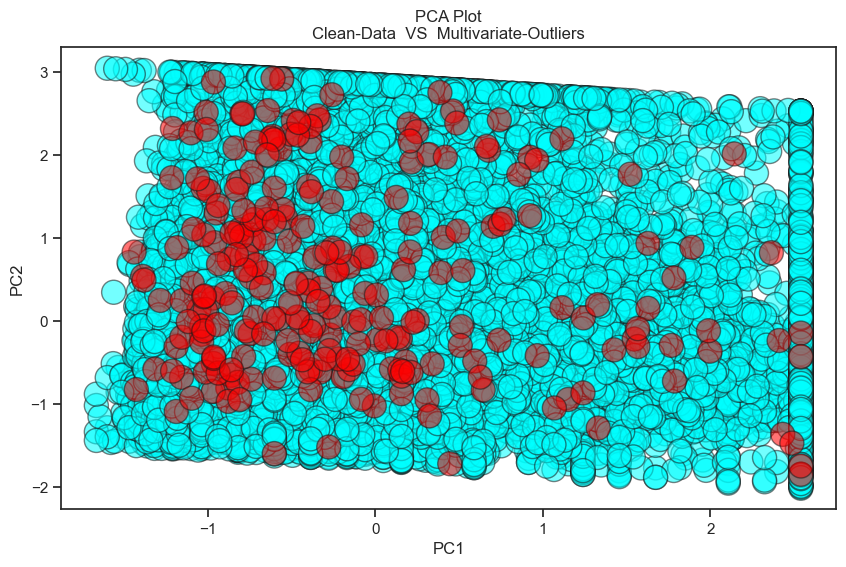

In [26]:
import numpy  as np
import pandas as pd
from sklearn.covariance    import MinCovDet
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

# Step 1: Feature selection
MD_Cols = Ss + D_dir_ind + D_cyc_ind_sin_cos + D_dir_dep + D_cyc_dep_sin_cos
df      = data[MD_Cols].copy().dropna()

# Step 2: Drop low-variance columns
# using std
low_var_cols = [ col for col in df.columns if df[col].std() < 1e-6 ]
df.drop(columns=low_var_cols, inplace=True)
# using MAD
low_var_cols = [ col for col in df.columns if np.median(np.abs(df[col] - df[col].median())) < 1e-6 ]
df.drop(columns=low_var_cols, inplace=True)

# Step 3: Drop highly correlated features
df = drop_highly_correlated_features(df, threshold=0.99, verbose=True)

# Step 4: Mahalanobis Distance Calculation
def try_mahalanobis(df):
    try:
        # Manual method
        cov      = np.cov(df, rowvar=False)
        inv_cov  = np.linalg.inv(cov)
        mean_vec = df.mean(axis=0).to_numpy()
        diff     = df.to_numpy() - mean_vec
        md       = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))
        print('Manual Method Selected')
        return md
    except:
        try:
            # Fallback to scipy
            mean_vec = df.mean(axis=0).to_numpy()
            cov      = np.cov(df, rowvar=False)
            inv_cov  = np.linalg.inv(cov)
            md       = [mahalanobis(x, mean_vec, inv_cov) for x in df.to_numpy()]
            print('Scipy Method Selected')
            return md
        except:
            # Final fallback to robust covariance
            robust_cov = MinCovDet().fit(df)
            print('Robust Method Selected')
            return robust_cov.mahalanobis(df)

md = try_mahalanobis(df)
md = [float(x) for x in md]

# Step 5: Outlier detection
index_list = multivar_outliers(df, md)

# Step 6: Outlier removal
df_no_multivar = remove_multivar_outliers(data, index_list)
df_multivar    = data.drop(df_no_multivar.index)
df_multivar.to_csv( 'df_MultiVar.csv', encoding='utf-8-sig' )

# Step 7: Report
print("Multivariate_Outliers =", round(len(df_multivar) / df.shape[0] * 100, 2), "%")

# Step 8: Visualization
Visualize(
    df_no_multivar,
    df_multivar,
    MD_Cols,
    'PCA Plot\nClean-Data  VS  Multivariate-Outliers',
    'PCA_02 Clean-Data  VS  Multivariate-Outliers.png'
)

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> df_MultiVar

In [27]:
df        = df_ImpVal.loc[:,['feature','problem']]
df['idx'] = df.index
df.index  = np.arange(df.shape[0])
Colors = []
Extreme_Imputed = False
for i in df.index:
    Problem = df.loc[i,'problem']
    if   Problem=='Extreme':  
        Colors.append("FFFF9999")
        Extreme_Imputed = True
    elif Problem=='Missing':  
        Colors.append("FFFFFF99")
    else:   print('Prblem is neither Extreme nor Missing:', i, Problem )
df['color'] = Colors
df_color = df.copy()

if Extreme_Imputed == False:   # == False: Winsorized      == True: Imputed
    df_Extreme  = pd.read_excel("df_Extreme.xlsx",header=0)
    df          = df_Extreme.loc[:,['feature','problem']]
    df['idx']   = df_Extreme['row']
    df.index    = np.arange( df_color.shape[0], df_color.shape[0]+df.shape[0] )
    df['color'] = ["FFFF9999"] * df.shape[0]  
    df_color    = pd.concat( [ df_color, df ], axis=0 )
    
display(df_color.sample(3).head(3))
display(df_multivar.sample(3).head(3))

feature  problem    idx     color
4072     population  Extreme  15530  FFFF9999
3763     population  Extreme   9240  FFFF9999
5139  median_income  Extreme   5501  FFFF9999

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
row                                                                           
8952     -118.47     34.01                  27         1782             471   
13982    -116.76     34.23                  10         4374             989   
1240     -120.34     38.23                  10         3757             722   

       population  households  median_income  median_house_value  \
row                                                                
8952          837         422         3.7727              413000   
13982        1020         376         2.6071               89000   
1240          546         223         3.7500              121400   

      ocean_proximity bin_num bin_cat  ord_num  ord_cat            datetime  \
row                                                                           
8952      <= 1H OCEAN     1.0     Yes        4        4 2020-06-10 11:16:54   
13982          INLAND     0.0      No        1        1 2024-06-13 00:00:00   
1240           INLAND     0.0      No        1        1 2017-08-24 04:00:00   

       year  age  elapsed_days  month  hour nominal_num nominal_cat  \
row                                                                   
8952   2008   21            56     11     4         3.0       Green   
13982  2005   27            68     10     8         0.0      Violet   
1240   2025   25           127      8    11         3.0       Green   

       datetime_year  datetime_quarter  datetime_month  datetime_dayofyear  \
row                                                                          
8952            2020                 2               6                  10   
13982           2024                 2               6                 165   
1240            2017                 3               8                 236   

       datetime_dayofmonth  datetime_dayofweek  datetime_hour  \
row                                                             
8952                    10                   2             11   
13982                   13                   3              0   
1240                    24                   3              4   

       datetime_minute  datetime_second  month_sin  month_cos  hour_sin  \
row                                                                       
8952                16               54  -0.500000   0.866025  0.866025   
13982                0                0  -0.866025   0.500000  0.866025   
1240                 0                0  -0.866025  -0.500000  0.258819   

       hour_cos  datetime_dayofmonth_sin  datetime_dayofmonth_cos  \
row                                                                 
8952   0.500000                 0.897805                -0.440394   
13982 -0.500000                 0.485302                -0.874347   
1240  -0.965926                -0.988468                 0.151428   

       datetime_dayofyear_sin  datetime_dayofyear_cos  datetime_dayofweek_sin  \
row                                                                             
8952                 0.170830                0.985301                0.974928   
13982                0.304115               -0.952635                0.433884   
1240                -0.789418               -0.613856                0.433884   

       datetime_dayofweek_cos  datetime_month_sin  datetime_month_cos  \
row                                                                     
8952                -0.222521        1.224647e-16                -1.0   
13982               -0.900969        0.000000e+00                -1.0   
1240                -0.900969       -8.660250e-01                -0.5   

       datetime_quarter_sin  datetime_quarter_cos  datetime_hour_sin  \
row                                                                    
8952           1.224647e-16                  -1.0           0.258819   
13982          0.000000e+00                  -1.0           0.000000   
1240          -1.00

In [28]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Save df_multivar first
output_file = "colored_multivar.xlsx"
df_multivar.to_excel(output_file, sheet_name="Sheet1")

# Load workbook with openpyxl
wb = load_workbook(output_file)
ws = wb["Sheet1"]

# Build column and row maps (Excel is 1-based, header row at 1)
col_map = {col: i+2 for i, col in enumerate(df_multivar.columns)}  # +2 because col A is index
row_map = {idx: i+2 for i, idx in enumerate(df_multivar.index)}    # +2 because row 1 is header

# Apply colors from df_color
for _, row in df_color.iterrows():
    idx     = row['idx']
    feature = row['feature']
    color   = row['color']  # hex like "FF0000" or "FFFF00"

    if idx in row_map and feature in col_map:
        excel_row = row_map[idx]
        excel_col = col_map[feature]
        cell = ws.cell(row=excel_row, column=excel_col)

        # Apply fill
        fill = PatternFill(start_color=color.replace("#",""), 
                           end_color=color.replace("#",""), 
                           fill_type="solid")
        cell.fill = fill

wb.save(output_file)
print('saved as ' + output_file)

saved as colored_multivar.xlsx


<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> df_Clean

In [29]:
COLS  =  DTs  +  D_dir_dep+D_cyc_dep  +  D_dir_ind+D_cyc_ind  +  Cs  +  Ss

df_Clean  =  df_no_multivar[ COLS ].copy()

# ord ==> str
for ft in My_Dicts.index:
    D     =  My_Dicts.loc[ft,'Dict']
    D_inv = {v: k for k, v in D.items()} 
    df_Clean[ft] = df_Clean[ft].astype("object").replace(D_inv)

df_Clean.to_csv( 'data_Clean.csv', encoding='utf-8-sig' )
df_Clean.head(3)

datetime  datetime_year  datetime_dayofmonth  \
row                                                           
2   2025-12-17 22:00:00           2025                   17   
3   2025-07-18 07:00:00           2025                   18   
4   2022-08-24 21:00:00           2022                   24   

     datetime_dayofyear datetime_dayofweek datetime_month  datetime_quarter  \
row                                                                           
2                   351                Wed            Dec                 4   
3                   199                Fri            Jul                 3   
4                   236                Wed            Aug                 3   

     datetime_hour  datetime_second  datetime_minute  age  year  elapsed_days  \
row                                                                             
2               22                0                0   27  2001           141   
3                7                0                0   35  2020             5   
4               21                0                0   43  2001            78   

     housing_median_age  month  hour ocean_proximity bin_num bin_cat  \
row                                                                    
2                    41     10    21        NEAR BAY     1.0     Yes   
3                    21      3    18        NEAR BAY     1.0     Yes   
4                    52      2     6        NEAR BAY     1.0     Yes   

    nominal_num nominal_cat  longitude  latitude  total_rooms  total_bedrooms  \
row                                                                             
2           0.0      Violet    -122.23     37.88          880             129   
3           2.0        Blue    -122.22     37.86         6634            1106   
4           3.0       Green    -122.24     37.85         1467             190   

     population  households  median_income  median_house_value  ord_num  \
row                                                                       
2           322         126         8.3252              452600        5   
3          2401        1138         8.3014              358500        4   
4           496         177         7.2574              352100        1   

       ord_cat  
row             
2    Very High  
3         High  
4     Very Low

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checkings

In [30]:
df_Clean[ My_Dicts.index ].head(3)

ord_cat datetime_month datetime_dayofweek
row                                             
2    Very High            Dec                Wed
3         High            Jul                Fri
4     Very Low            Aug                Wed

In [31]:
df_Clean[ Cs ].head(3)

ocean_proximity bin_num bin_cat nominal_num nominal_cat
row                                                        
2          NEAR BAY     1.0     Yes         0.0      Violet
3          NEAR BAY     1.0     Yes         2.0        Blue
4          NEAR BAY     1.0     Yes         3.0       Green

In [32]:
df_Clean[ DTs ].head(3)

datetime
row                    
2   2025-12-17 22:00:00
3   2025-07-18 07:00:00
4   2022-08-24 21:00:00

In [33]:
df_Clean[ D_dir_dep ].head(3)

datetime_year
row               
2             2025
3             2025
4             2022

In [34]:
df_Clean[ D_cyc_dep ].head(3)

datetime_dayofmonth  datetime_dayofyear datetime_dayofweek  \
row                                                               
2                     17                 351                Wed   
3                     18                 199                Fri   
4                     24                 236                Wed   

    datetime_month  datetime_quarter  datetime_hour  datetime_second  \
row                                                                    
2              Dec                 4             22                0   
3              Jul                 3              7                0   
4              Aug                 3             21                0   

     datetime_minute  
row                   
2                  0  
3                  0  
4                  0

In [35]:
df_Clean[ D_dir_ind ].head(3)

age  year  elapsed_days  housing_median_age
row                                             
2     27  2001           141                  41
3     35  2020             5                  21
4     43  2001            78                  52

In [36]:
df_Clean[ D_cyc_ind ].head(3)

month  hour
row             
2       10    21
3        3    18
4        2     6

In [37]:
df_Clean[ Ss ].head(3)

longitude  latitude  total_rooms  total_bedrooms  population  households  \
row                                                                             
2      -122.23     37.88          880             129         322         126   
3      -122.22     37.86         6634            1106        2401        1138   
4      -122.24     37.85         1467             190         496         177   

     median_income  median_house_value  ord_num    ord_cat  
row                                                         
2           8.3252              452600        5  Very High  
3           8.3014              358500        4       High  
4           7.2574              352100        1   Very Low

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Hist + Kde of Scalars
 - **Outlier Handling Explanation (for client notes)**

“In your dataset, there were a few extreme values (outliers) that could have distorted the model’s performance. Instead of removing them completely, I applied a technique called capping (also known as winsorization). This means I limited extreme values to a reasonable boundary, so they don’t dominate the analysis while still keeping all of your data points in the model.

This approach helps stabilize the results, improves accuracy, and ensures the model learns from the full dataset without being misled by unrealistic extremes."

In [38]:
# Select numeric columns, excluding 'row'
NUMs = Ss + D_dir_ind+D_dir_dep #+ D_cyc_ind+D_cyc_dep
NUMs = [ col for col in NUMs if col in df_Dirty ]
NUMs = [ col for col in NUMs if col not in My_Dicts.index ]
NUMs = [ col for col in NUMs if df_Clean[col].dtype not in ['object','category'] ]

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> No_Multivar (Clean)

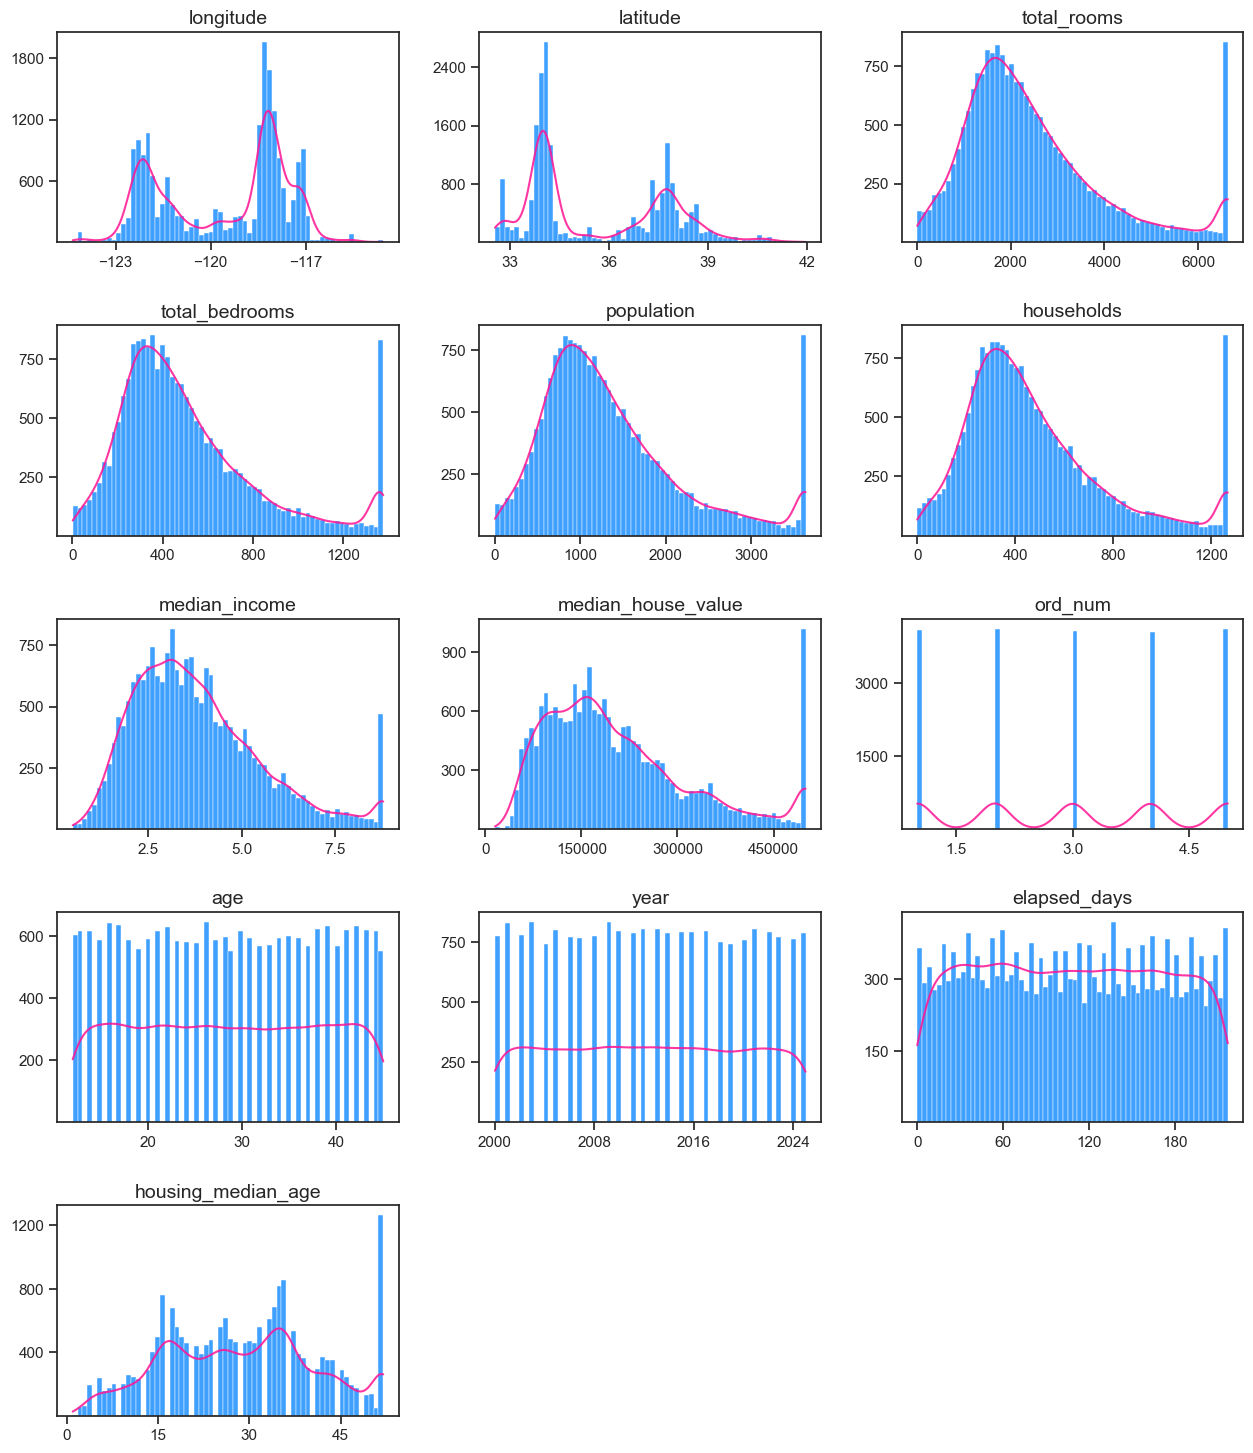

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator

df = df_Clean

# Grid layout
n_cols = 3
n_rows = math.ceil(len(NUMs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=( 13, 15))
axes = axes.flatten()

for i, col in enumerate(NUMs):
    col_df = df[col].dropna()

    # Plot histogram with KDE on same axis
    sns.histplot(col_df, bins=64, color='dodgerblue', kde=True, alpha=0.85, ax=axes[i])

    # Recolor KDE line to deeppink
    for line in axes[i].lines:
        line.set_color('deeppink')
        line.set_alpha(0.85)

    # Clean up labels and ticks
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))

# Remove unused axes
for j in range(len(NUMs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
fig.savefig("Hist_Kde_Clean.png", dpi=300, bbox_inches='tight')  # png pdf svg

plt.show()

#####   

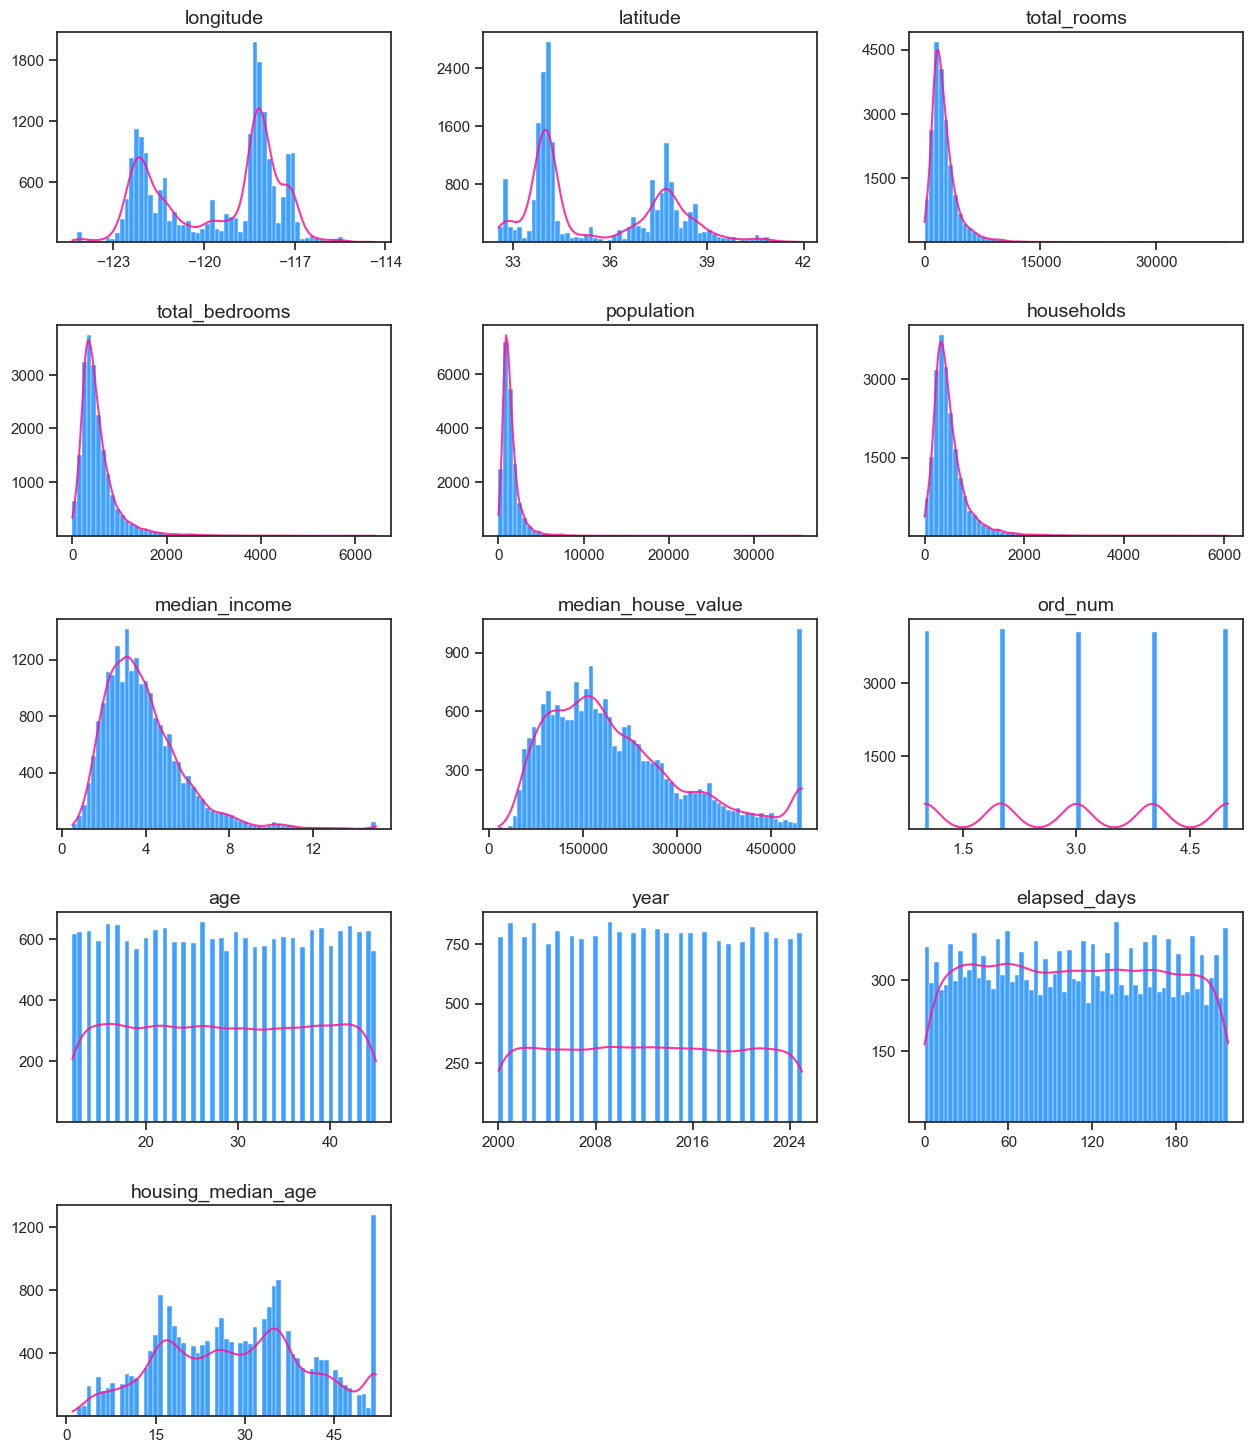

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator

df = df_Dirty

# Grid layout
n_cols = 3
n_rows = math.ceil(len(NUMs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=( 13, 15))
axes = axes.flatten()

for i, col in enumerate(NUMs):
    col_df = df[col].dropna()

    # Plot histogram with KDE on same axis
    sns.histplot(col_df, bins=64, color='dodgerblue', kde=True, alpha=0.85, ax=axes[i])

    # Recolor KDE line to deeppink
    for line in axes[i].lines:
        line.set_color('deeppink')
        line.set_alpha(0.85)

    # Clean up labels and ticks
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))

# Remove unused axes
for j in range(len(NUMs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
fig.savefig("Hist_Kde_Dirty.png", dpi=300, bbox_inches='tight')  # png pdf svg

plt.show()

#####   

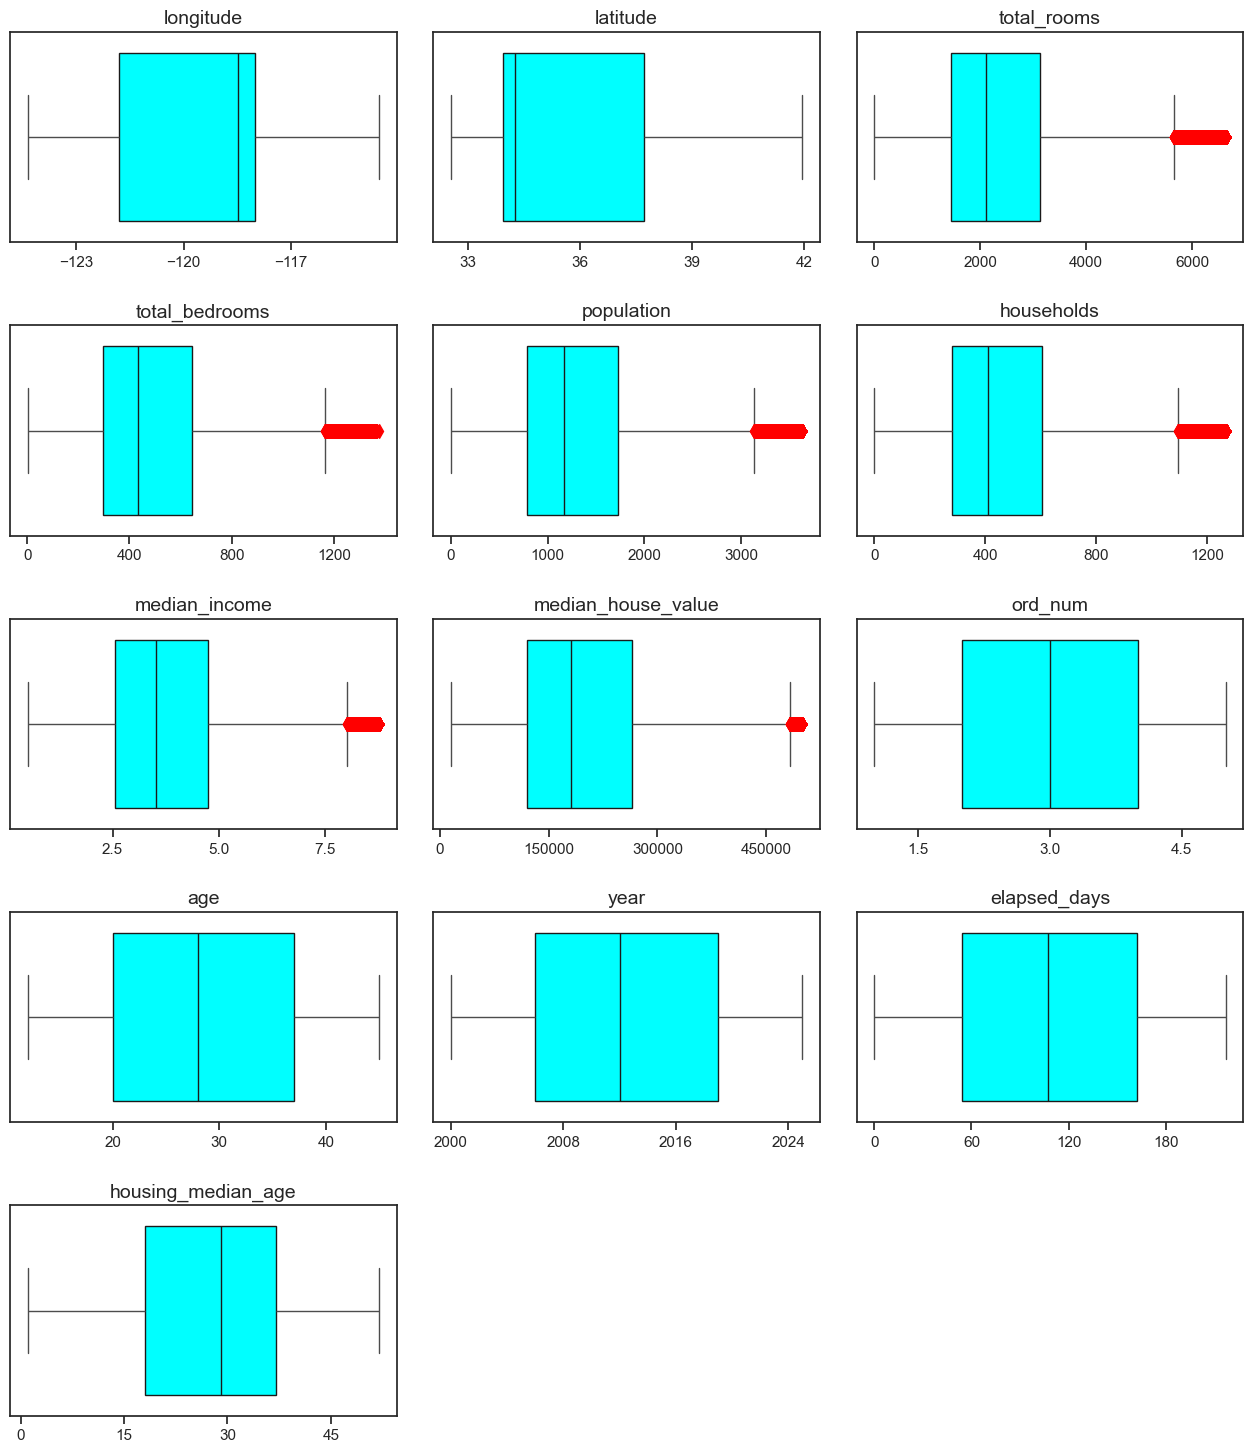

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator

df = df_Clean

# Grid layout
n_cols = 3
n_rows = math.ceil(len(NUMs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 15))
axes = axes.flatten()

# Boxplot styling
boxprops    = dict(linewidth=1, edgecolor='k', facecolor='cyan')
medianprops = dict(linewidth=1, color='k')
flierprops  = dict(marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red')

for i, col in enumerate(NUMs):
    col_data = df[col].dropna()

    # Plot boxplot
    sns.boxplot(
        data=col_data.to_frame(),
        x=col,
        ax=axes[i],
        boxprops=boxprops,
        medianprops=medianprops,
        flierprops=flierprops
    )

    # Clean up labels and ticks
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].tick_params(axis='y', left=False, labelleft=False)  # 👈 Remove y-ticks

# Remove unused axes
for j in range(len(NUMs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
fig.savefig("Boxplot_Clean.png", dpi=300, bbox_inches='tight')

plt.show()

#####   

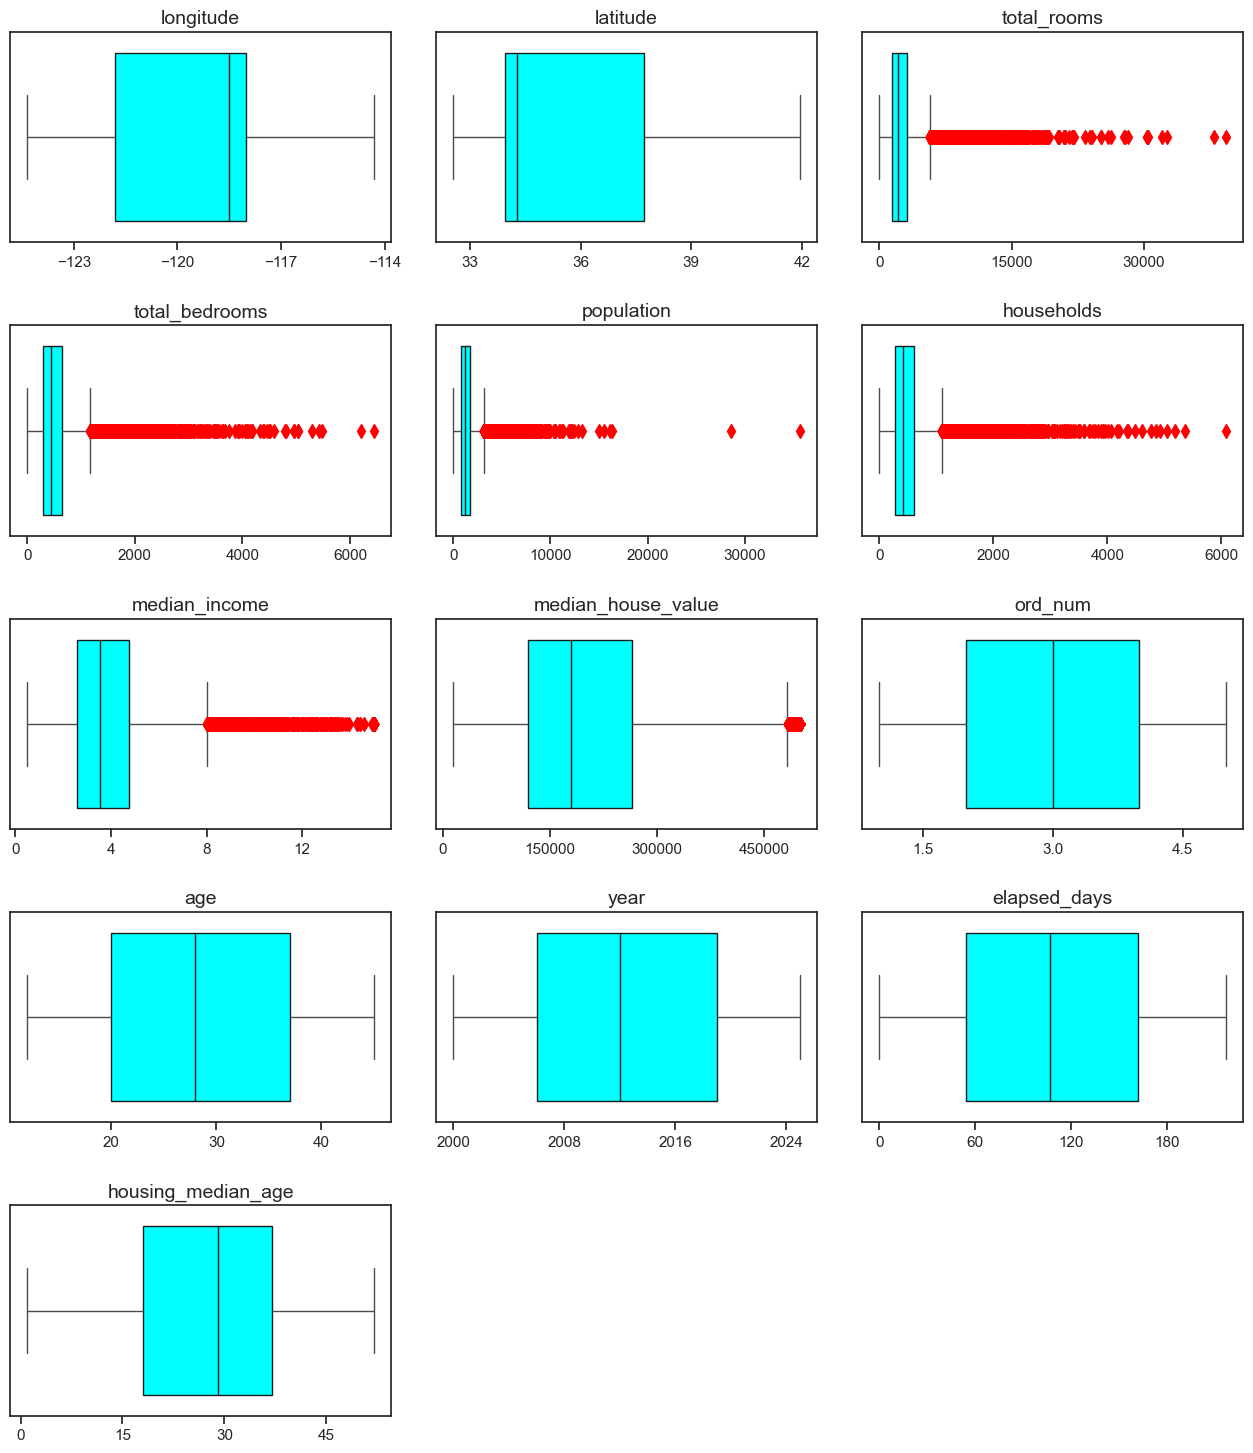

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator

df = df_Dirty

# Grid layout
n_cols = 3
n_rows = math.ceil(len(NUMs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 15))
axes = axes.flatten()

# Boxplot styling
boxprops    = dict(linewidth=1, edgecolor='k', facecolor='cyan')
medianprops = dict(linewidth=1, color='k')
flierprops  = dict(marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red')

for i, col in enumerate(NUMs):
    col_data = df[col].dropna()

    # Plot boxplot
    sns.boxplot(
        data=col_data.to_frame(),
        x=col,
        ax=axes[i],
        boxprops=boxprops,
        medianprops=medianprops,
        flierprops=flierprops
    )

    # Clean up labels and ticks
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].tick_params(axis='y', left=False, labelleft=False)  # 👈 Remove y-ticks

# Remove unused axes
for j in range(len(NUMs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
fig.savefig("Boxplot_Dirty.png", dpi=300, bbox_inches='tight')

plt.show()

#####   

#####   

In [43]:
import time
t2 = time.time()
print( round((t2-t1)/60,0) , ' min' )

1.0  min


<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> END

🎯 Fiverr Gig Blueprint (Refined)
1. Gig Title
“I will clean, preprocess, and impute your CSV or Excel dataset (up to 10,000 rows) with advanced ML”

2. Search Tags
data cleaning

csv excel preprocessing

missing value imputation

feature engineering

machine learning

3. Gig Description
Tired of messy, incomplete, or inconsistent data slowing down your project? I will transform your CSV or Excel dataset (up to 10,000 records) into a clean, structured, and analysis‑ready format using advanced machine learning and statistical techniques.

🔧 What I Do
Data Cleaning

Remove garbage tokens, whitespace, and duplicates

Detect and report false zeros

Handle extreme univariate outliers (drop, impute, or winsorize)

Detect multivariate outliers using Mahalanobis distance

Feature Engineering

Split composite features (e.g. aaa@bbb@ccc → ft1, ft2, ft3)

Correct inconsistent category labels

Extract rich temporal features (year, quarter, month, weekday, hour, etc.)

Convert ordinal categories into numeric scalars

Convert binary and false scalar features into categorical

Missing Value Imputation

Numeric features: regression blend of LightGBM + CatBoost, with KNN fallback

Categorical features: classification blend of LightGBM + CatBoost, with clustering fallback

Detailed reporting of every imputed value

Outlier & Imputation Reporting

Boxplots (before vs after cleaning)

Histograms + KDE plots (dirty vs clean features)

Scatter plots showing outlier values before/after imputation

PCA scatter plot highlighting multivariate outliers vs clean data

📊 Deliverables
Clean dataset (CSV/Excel, ready for analysis or modeling)

Separate dataframe of eliminated multivariate outliers

Excel reports of duplicates, false zeros, and imputed values

Visual plots for transparency and validation

⚠️ Scope: I work with CSV and Excel files only, and support small to medium datasets (up to 10,000 rows).

4. Packages
Package	Price (example)	Delivery	Includes
Basic	$20	2 days	Clean CSV/Excel (≤10k rows): garbage removal, duplicates, false zeros, dtype optimization
Standard	$50	3 days	Basic + feature engineering (temporal extraction, categorical encoding, outlier detection with reports)
Premium	$100	5 days	Standard + advanced imputation (LightGBM + CatBoost + KNN/Clustering), full reporting, plots, and two final datasets
5. FAQs
Q: What file formats do you accept? A: Only CSV and Excel files.

Q: What dataset sizes do you support? A: Small to medium datasets, up to 10,000 rows.

Q: Can you handle missing values? A: Yes — I use LightGBM + CatBoost blends with KNN/Clustering fallback for robust imputation.

Q: Will I get reports of what was changed? A: Yes — I provide Excel reports and plots showing duplicates, false zeros, outliers, and imputed values.

Q: Can you customize the pipeline for my project? A: Absolutely — thresholds, imputation strategies, and reporting can be tailored to your needs.

6. Gig Images / Portfolio Ideas
Infographic: “Raw CSV → Clean Data → Analysis Ready”

Example plots: before/after boxplots, PCA scatter plot with outliers highlighted

Flowchart of your pipeline (Cleaning → Feature Engineering → Imputation → Reporting)

✨ With these refinements, your gig is now crystal clear: CSV/Excel only, up to 10,000 rows. That sets client expectations and positions you as a specialist in small‑to‑medium dataset preprocessing.

Would you like me to also draft sample gig images text (captions/labels) so you can quickly design visuals that match this description?

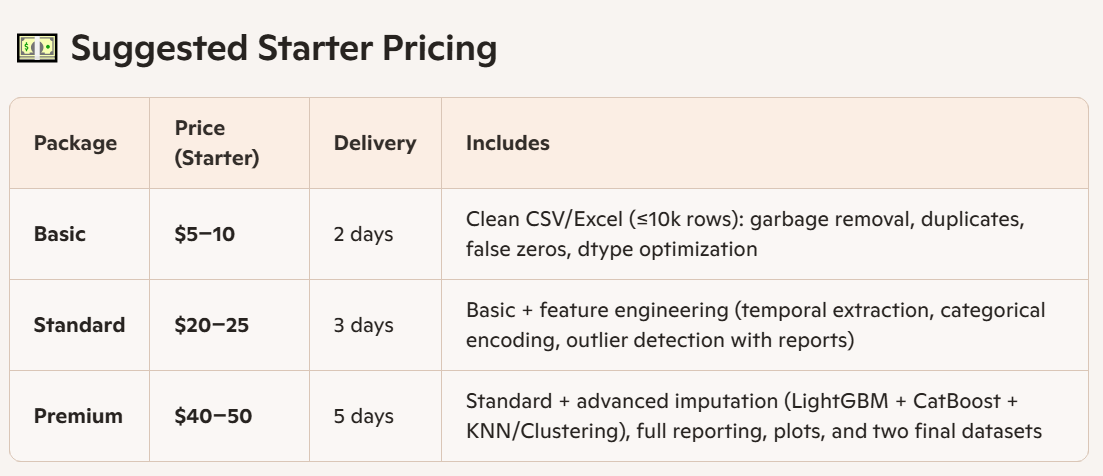

#####   

In [44]:
import pandas as pd
import plotly.express as px

# Define cyclical features and their max values
CYC_MAX = {
    'hour': 24,
    'minute': 60,
    'second': 60,
    'weekday': 7,
    'month': 12,
    'quarter': 4
}

def plot_cyclical_polar(df, feature, color="royalblue", opacity=0.7):
    """
    Plotly polar bar chart for cyclical temporal features.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with temporal features.
    feature : str
        Column name (e.g., 'hour', 'weekday', 'month').
    color : str
        Bar color
    opacity : float
        Transparency (0 to 1)
    """
    if feature not in CYC_MAX:
        raise ValueError(f"{feature} not recognized. Choose from {list(CYC_MAX.keys())}.")
    max_val = CYC_MAX[feature]

    # Count occurrences per bin
    counts = df[feature].value_counts().sort_index()
    counts = counts.reindex(range(max_val), fill_value=0)

    # Convert to degrees for polar axis
    temp = pd.DataFrame({
        "theta": 360.0 * counts.index / max_val,
        "r": counts.values
    })

    # Polar bar chart
    fig = px.bar_polar(
        temp, theta="theta", r="r",
        color_discrete_sequence=[color],
        title=f"Polar Distribution of {feature.capitalize()}"
    )

    # Orientation: 0 at top, clockwise
    fig.update_polars( angularaxis = dict( direction="clockwise", rotation=90 ) )
    # Apply transparency
    fig.update_traces(opacity=opacity)

    fig.show()

# Example dataset
df = pd.DataFrame({
    "hour"   : pd.Series( [1, 3, 4, 7, 23, 0]*15 + [6,9,20]*10 ),
    "weekday": pd.Series( [0,1,2,3,4,5,6]*20 )
}) 
plot_cyclical_polar(  df, "hour"   , color="tomato"  , opacity=0.6 ) 
#plot_cyclical_polar( df, "weekday", color="seagreen", opacity=0.8 )

#####   

#####   